### CIS 600 Natural Language Processing Project
# Distinguishing Mental Health Categories on Reddit Using NLP

# 1. Data Collection


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from collections import Counter, defaultdict

# Load the dataset, dropping the first column and displaying the first few rows.
data = pd.read_csv('mental_health_data.csv').iloc[:, 1:]
data.head()

,title,body,author,url,score,upvote_ratio,subreddit
0,Craving closeness,"About a year ago, I got into a relationship th...",Nash4N00b,https://www.reddit.com/r/mentalhealth/comments...,2,1.00,mentalhealth
1,Mental health class,I think schools should have a mandatory mental...,ConnecticutJohn,https://www.reddit.com/r/mentalhealth/comments...,112,0.97,mentalhealth
2,My 7yo son accidentally fell on our pet bird a...,It was TRULY a freak accident and not expected...,AnonymousCounselor52,https://www.reddit.com/r/mentalhealth/comments...,387,0.97,mentalhealth
3,Who else doesn’t want covid world to leave,My mental health has been so bad and I’ve been...,jjdabest8820,https://www.reddit.com/r/mentalhealth/comments...,15,0.94,mentalhealth
4,my mental health is suffering due to my contro...,note: please read my previous posts for contex...,Wooden_View_7120,https://www.reddit.com/r/mentalhealth/comments...,7,0.83,mentalhealth


In [ ]:
data.shape

(6239, 7)

### 1.1 Bar chart to represent Subreddit Categories
Subreddits vs Count



<Axes: xlabel='count', ylabel='subreddit'>

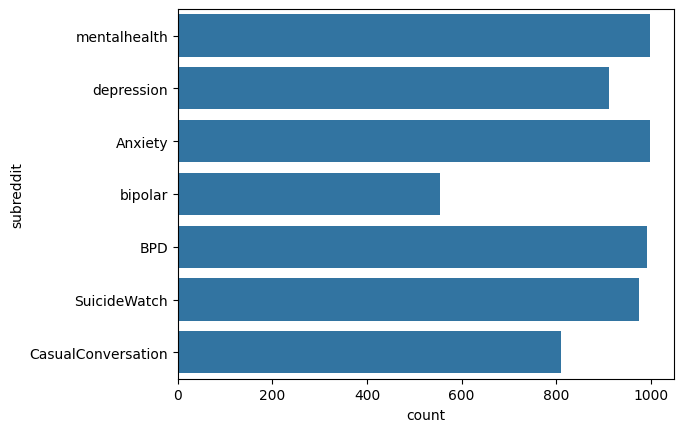

In [ ]:
# Countplot by subreddit
sns.countplot(data=data, y="subreddit")

## 2. Data Pre-Processing
### 2.1 Data Cleaning

In [ ]:
# Here we check if there are any missing values in the dataframe
data.isna().sum()

,0
title,0
body,316
author,26
url,0
score,0
upvote_ratio,0
subreddit,0


In [ ]:
# When the author is missing is because the account has been cancelled.
# This is not a problem for the analysis.

data[data['author'].isna()].reset_index()['url'][:5]

,url
0,https://www.reddit.com/r/mentalhealth/comments...
1,https://www.reddit.com/r/mentalhealth/comments...
2,https://www.reddit.com/r/mentalhealth/comments...
3,https://www.reddit.com/r/depression/comments/n...
4,https://www.reddit.com/r/depression/comments/n...


In [ ]:
# How are the missing values for the body feature distribted accross subreddits?
# As we can see, r/bipolar stands out

data[data['body'].isna()].groupby('subreddit').count()['title']

,title
subreddit,
Anxiety,20
SuicideWatch,45
bipolar,232
depression,7
mentalhealth,12


In [ ]:
# For r/bipolar, the body is missing because most posts are either memes, videos or links to other websites.

data[(data['body'].isna()) & (data['subreddit']=='bipolar')].reset_index()['url'][:5]

,url
0,https://i.redd.it/inr6td85lrw61.jpg
1,https://i.redd.it/6hgatwtv0rw61.jpg
2,https://www.reddit.com/gallery/n3p1t5
3,https://i.redd.it/35rj80rxtqw61.jpg
4,https://i.redd.it/2mirmpc2duw61.jpg


In [ ]:
# For this subreddit, it is better to delete all data points with missing values for the body feature.
# The same is true for r/mentalhealth.

data = data[~((data['body'].isna()) & (data['subreddit'].isin(['bipolar', 'mentalhealth'])))].reset_index().drop('index', axis=1)

In [ ]:
# For r/SuicideWatch the situation is different: the body is missing simply because the author decided to write only the title.
# Another reason is because the post has been deleted by the author.

data[(data['body'].isna()) & (data['subreddit']=='SuicideWatch')].reset_index()['url'][:5]

,url
0,https://www.reddit.com/r/SuicideWatch/comments...
1,https://www.reddit.com/r/SuicideWatch/comments...
2,https://www.reddit.com/r/SuicideWatch/comments...
3,https://www.reddit.com/r/SuicideWatch/comments...
4,https://www.reddit.com/r/SuicideWatch/comments...


<Axes: xlabel='count', ylabel='subreddit'>

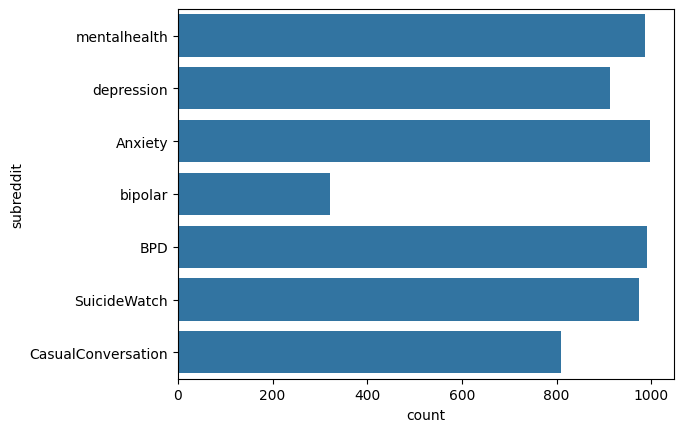

In [ ]:
# Fill remaining missing values in the dataset with an empty string.
data.fillna('', inplace=True)

# Visualize the updated distribution of posts across subreddits.
sns.countplot(y="subreddit", data=data)


In [ ]:
# We get almost 6000 documents after the cleaning
data.shape

(5995, 7)

In [ ]:
# Combine the 'title' and 'body' columns into a new 'full_text' feature.
data['full_text'] = data[['title', 'body']].agg(' '.join, axis=1)

## 2.2 Reddit Specific Pre-Processing

In [ ]:
def reddit_specific_preprocessing(text):

    # Remove newlines (one or more)
    text = re.sub(r'\n+', ' ', text)

    # Remove quotes
    text = re.sub(r'\"?\\?&?gt;?', '', text)

    # Remove asterisk
    text = re.sub(r'\*', '', text)

    # Remove bullet points
    text = re.sub('&amp;#x200B;', '', text)

    # Remove links (always enclosed between parenthesis)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    # Remove strikethroughs
    text = re.sub('~', '', text)

    # Remove spoilers, which is used with < less-than (Preserves the text)
    text = re.sub('&lt;', '', text)
    text = re.sub(r'!(.*?)!', r'\1', text)

    # Code, inline and block
    text = re.sub('`', '', text)

    # Superscript (Preserves the text)
    text = re.sub(r'\^\((.*?)\)', r'\1', text)

    # Table
    text = re.sub(r'\|', ' ', text)
    text = re.sub(':-', '', text)

    # Heading
    text = re.sub('#', '', text)

    # Clean white spaces
    text = text.strip()
    text = re.sub(r'\s\s+', ' ', text)

    return text

In [ ]:
# New dataframe to show the different preprocessing steps.
# Let us include the url to serve as a key to later join it with the original data.

df_preprocessing = data[['url', 'full_text']].copy()

In [ ]:
df_preprocessing.head()

,url,full_text
0,https://www.reddit.com/r/mentalhealth/comments...,"Craving closeness About a year ago, I got into..."
1,https://www.reddit.com/r/mentalhealth/comments...,Mental health class I think schools should hav...
2,https://www.reddit.com/r/mentalhealth/comments...,My 7yo son accidentally fell on our pet bird a...
3,https://www.reddit.com/r/mentalhealth/comments...,Who else doesn’t want covid world to leave My ...
4,https://www.reddit.com/r/mentalhealth/comments...,my mental health is suffering due to my contro...


In [ ]:
# All the preprocessing steps are sequentials

df_preprocessing['step_01_reddit_cleanup'] = df_preprocessing['full_text'].apply(lambda text: reddit_specific_preprocessing(text))

In [ ]:
df_preprocessing['step_01_reddit_cleanup'][0]

'Craving closeness About a year ago, I got into a relationship that lasted until December 2020. I was the one that broke up. I loved her, but I didn’t see a satisfying future for me, so it was a tough decision to make. The problem is that I now really crave the closeness I had with her, cause I don’t really get that with anyone else. I want the love we had for each other with someone else, and it’s really annoying. I want the spooning, the sex, everything. I’m only 18, so it’s probably not something I should be thinking about, but I do. Is this normal, or should I seek help?'

### 2.3 Stopword Removal

In [ ]:
!pip install nltk
import nltk

# Download the 'stopwords' dataset from NLTK (Natural Language Toolkit)
nltk.download('stopwords')

from nltk.corpus import stopwords

# Create a set of English stopwords
STOPWORDS = set(stopwords.words('english'))

# Define a function to remove stopwords from a given text
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# Apply the 'remove_stopwords' function to the 'step_01_reddit_cleanup' column and create a new column for the cleaned text
df_preprocessing['step_02_remove_stopwords'] = df_preprocessing['step_01_reddit_cleanup'].apply(lambda text: remove_stopwords(text))

# Display the first cleaned text from the '02_remove_stopwords' column
df_preprocessing['step_02_remove_stopwords'][0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'Craving closeness About year ago, I got relationship lasted December 2020. I one broke up. I loved her, I didn’t see satisfying future me, tough decision make. The problem I really crave closeness I her, cause I don’t really get anyone else. I want love someone else, it’s really annoying. I want spooning, sex, everything. I’m 18, it’s probably something I thinking about, I do. Is normal, I seek help?'

### 2.4 Remove punctuation

In [ ]:
import string

PUNCTUATION = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATION))

df_preprocessing['step_03_remove_punctuation'] = df_preprocessing['step_02_remove_stopwords'].apply(lambda text: remove_punctuation(text))

df_preprocessing['step_03_remove_punctuation'][0]

'Craving closeness About year ago I got relationship lasted December 2020 I one broke up I loved her I didn’t see satisfying future me tough decision make The problem I really crave closeness I her cause I don’t really get anyone else I want love someone else it’s really annoying I want spooning sex everything I’m 18 it’s probably something I thinking about I do Is normal I seek help'

### 2.5 Lemmatization

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Define lemmatization function with optional POS filtering
def lemmatize(text, pos_list=None):
    return [token.lemma_ for token in nlp(text) if not pos_list or token.pos_ in pos_list]

# Apply standard lemmatization
df_preprocessing['lemmatization_standard'] = df_preprocessing['step_03_remove_punctuation'].apply(lambda text: ' '.join(lemmatize(text)))

print('Output of Standard Lemmatization on the dataset:\n',df_preprocessing['lemmatization_standard'][0])

# Apply lemmatization keeping only nouns and adjectives
pos_list = ['NOUN', 'ADJ']
df_preprocessing['lemmatization_noun_adj'] = df_preprocessing['step_03_remove_punctuation'].apply(lambda text: ' '.join(lemmatize(text, pos_list)))

print('Output of lemmatization on only nouns and adjectives of the dataset:\n',df_preprocessing['lemmatization_noun_adj'][0])


Output of Standard Lemmatization on the dataset:
 crave closeness about year ago I get relationship last December 2020 I one break up I love she I do not see satisfy future I tough decision make the problem I really crave closeness I her cause I do not really get anyone else I want love someone else it ’ really annoying I want spoon sex everything I ’m 18 it ’ probably something I think about I do be normal I seek help
Output of lemmatization on only nouns and adjectives of the dataset:
 closeness year relationship future tough decision problem closeness love annoying sex normal help


In [ ]:
# Save dataset
df_preprocessing.to_csv('data_preprocessed.csv')

In [ ]:
# Upload dataset

df_preprocessing = pd.read_csv('data_preprocessed.csv')

In [ ]:
df_preprocessing.head()

,Unnamed: 0,url,full_text,step_01_reddit_cleanup,step_02_remove_stopwords,step_03_remove_punctuation,lemmatization_standard,lemmatization_noun_adj
0,0,https://www.reddit.com/r/mentalhealth/comments...,"Craving closeness About a year ago, I got into...","Craving closeness About a year ago, I got into...","Craving closeness About year ago, I got relati...",Craving closeness About year ago I got relatio...,crave closeness about year ago I get relations...,closeness year relationship future tough decis...
1,1,https://www.reddit.com/r/mentalhealth/comments...,Mental health class I think schools should hav...,Mental health class I think schools should hav...,Mental health class I think schools mandatory ...,Mental health class I think schools mandatory ...,mental health class I think school mandatory m...,mental health class school mandatory mental he...
2,2,https://www.reddit.com/r/mentalhealth/comments...,My 7yo son accidentally fell on our pet bird a...,My 7yo son accidentally fell on our pet bird a...,My 7yo son accidentally fell pet bird killed 1...,My 7yo son accidentally fell pet bird killed 1...,my 7yo son accidentally fall pet bird kill 11 ...,7yo son bird son help advice trauma first expe...
3,3,https://www.reddit.com/r/mentalhealth/comments...,Who else doesn’t want covid world to leave My ...,Who else doesn’t want covid world to leave My ...,Who else doesn’t want covid world leave My men...,Who else doesn’t want covid world leave My men...,who else do not want covid world leave my ment...,covid world mental health bad battle life anxi...
4,4,https://www.reddit.com/r/mentalhealth/comments...,my mental health is suffering due to my contro...,my mental health is suffering due to my contro...,mental health suffering due controlling toxic ...,mental health suffering due controlling toxic ...,mental health suffering due control toxic hous...,mental health suffering due toxic household no...


### 2.6 Pre-Analysis for data

In [ ]:
df_preprocessing = df_preprocessing.merge(data[['url', 'subreddit']], on='url')

In [ ]:
#Categories of subreddits available in the dataset
subreddits = list(set(df_preprocessing['subreddit']))
subreddits

['mentalhealth',
 'SuicideWatch',
 'bipolar',
 'CasualConversation',
 'Anxiety',
 'depression',
 'BPD']

## 3. Exploratory Data Analysis (EDA)

### 3.1 Number of characters

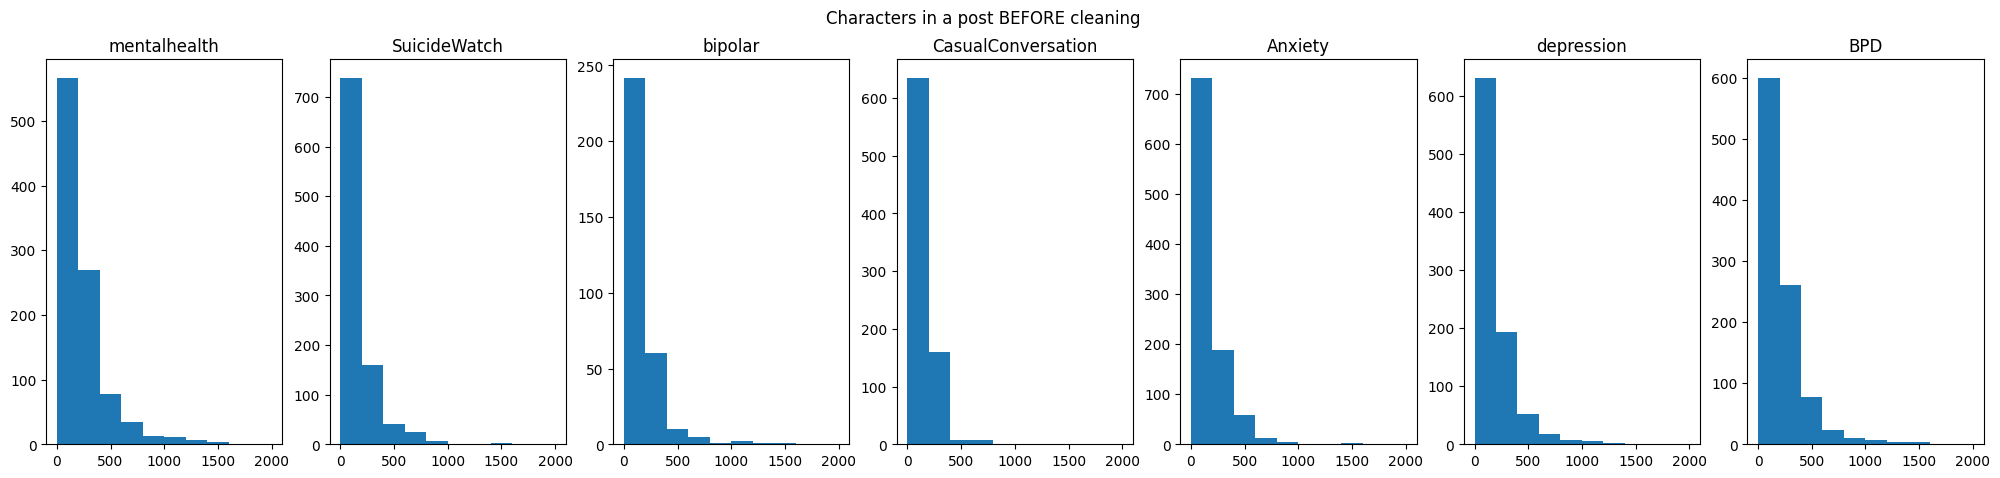

In [ ]:
# Number of characters in post BEFORE cleaning

fig, ax= plt.subplots(1, len(subreddits) ,figsize=(25,5))

for i, sub in enumerate(subreddits):

    text_len = df_preprocessing[df_preprocessing['subreddit']==sub]['full_text'].str.split().map(lambda x: len(x))
    ax[i].hist(text_len, range=(0, 2000))
    ax[i].set_title(sub)

fig.suptitle('Characters in a post BEFORE cleaning')
plt.show()

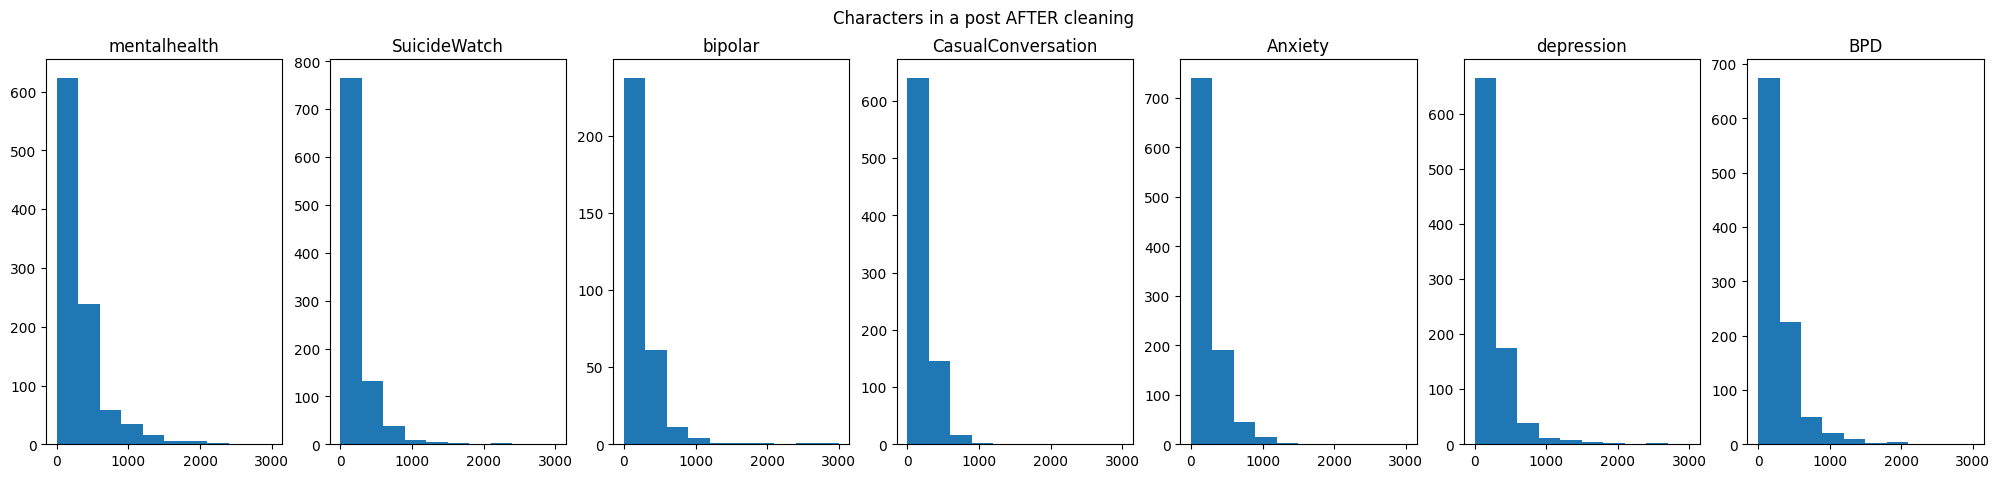

In [ ]:
# Numbers characters in text AFTER cleaning

fig, ax= plt.subplots(1, len(subreddits) ,figsize=(25,5))

for i, sub in enumerate(subreddits):

    text_len = df_preprocessing[df_preprocessing['subreddit']==sub]['lemmatization_noun_adj'].str.len()
    ax[i].hist(text_len, range=(0, 3000))
    ax[i].set_title(sub)

fig.suptitle('Characters in a post AFTER cleaning')
plt.show()

### 3.2 Number of words

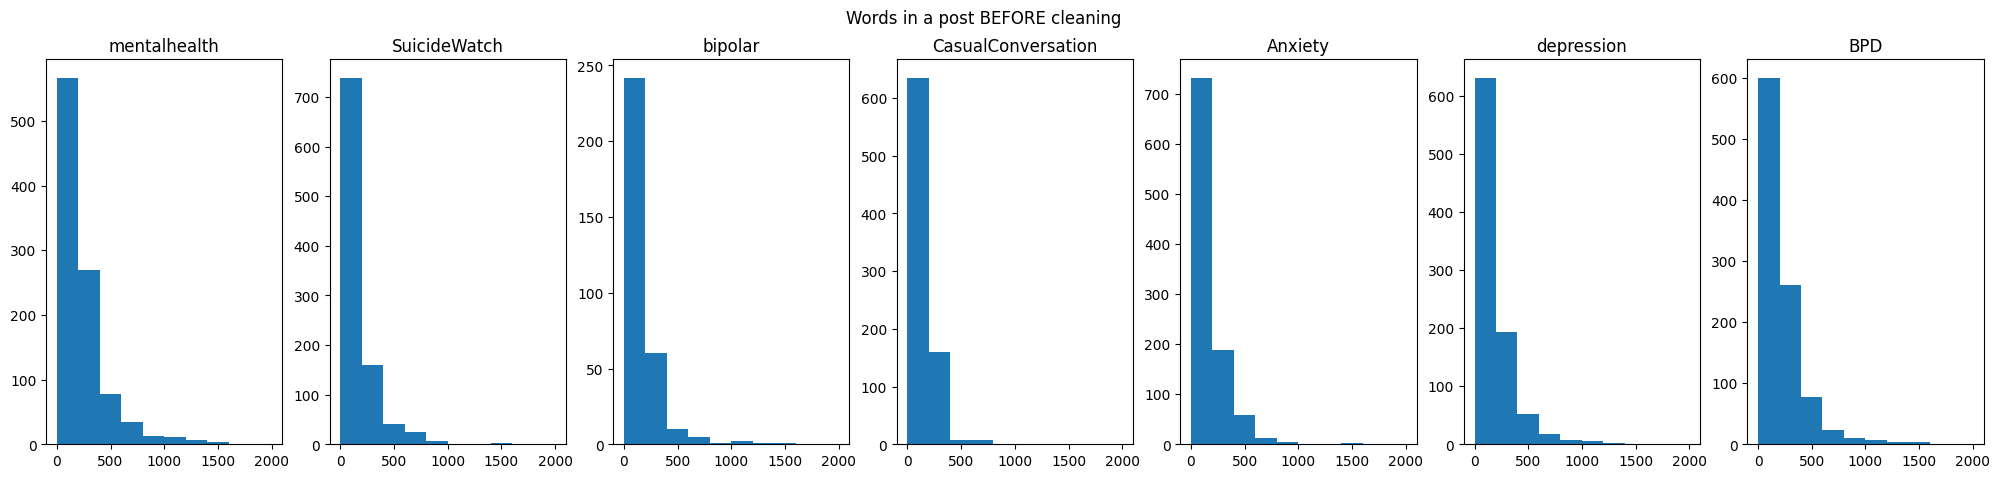

In [ ]:
# Numbers words in text BEFORE cleaning

fig, ax= plt.subplots(1, len(subreddits) ,figsize=(25,5))

for i, sub in enumerate(subreddits):

    text_len = df_preprocessing[df_preprocessing['subreddit']==sub]['full_text'].str.split().map(lambda x: len(x))
    ax[i].hist(text_len, range=(0, 2000))
    ax[i].set_title(sub)

fig.suptitle('Words in a post BEFORE cleaning')
plt.show()

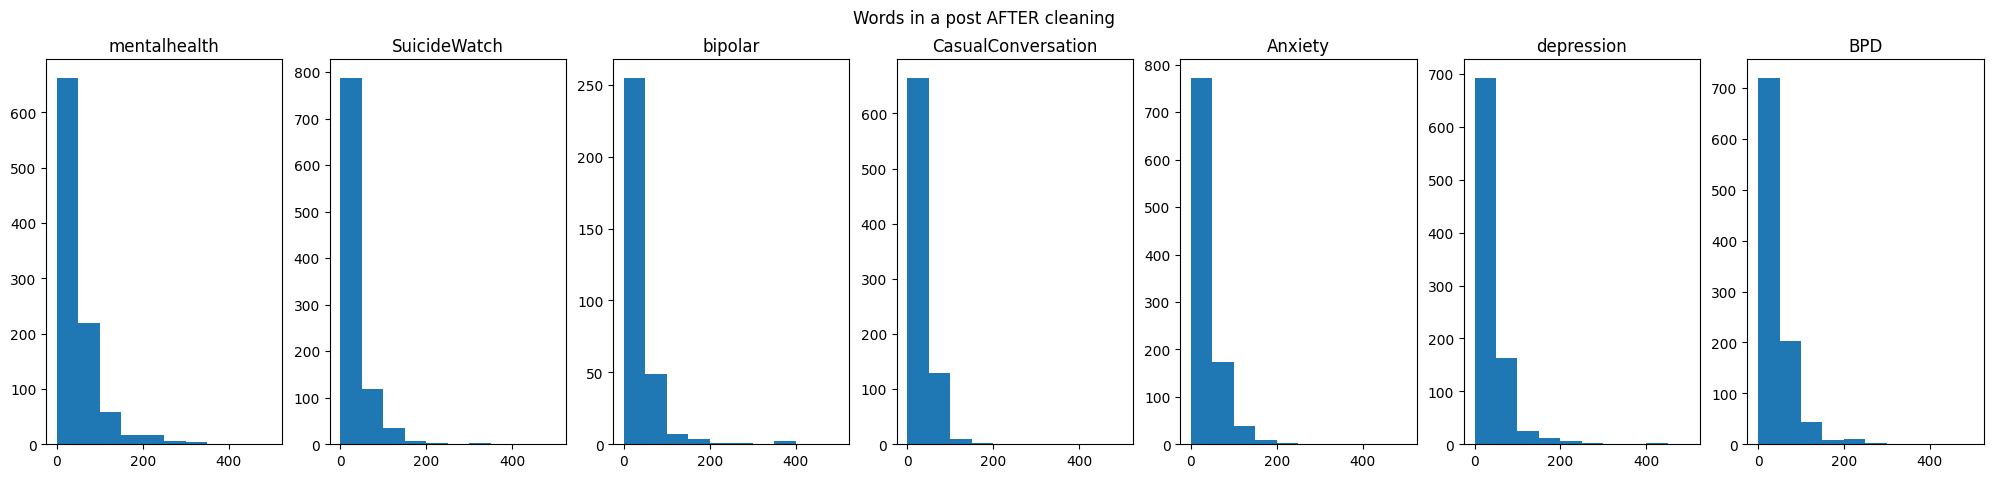

In [ ]:
# Numbers words in text AFTER cleaning

fig, ax= plt.subplots(1, len(subreddits) ,figsize=(25,5))

for i, sub in enumerate(subreddits):

    # Access the 'lemmatization_noun_adj' column for the current subreddit
    text_data = df_preprocessing[df_preprocessing['subreddit']==sub]['lemmatization_noun_adj']

    # Drop any NaN values in the text_data Series before proceeding
    text_data = text_data.dropna()

    # Calculate the length of each text after splitting
    text_len = text_data.str.split().map(lambda x: len(x))

    # Create the histogram for the current subreddit
    ax[i].hist(text_len, range=(0, 500))
    ax[i].set_title(sub)

fig.suptitle('Words in a post AFTER cleaning')
plt.show()

### 3.3 Bag of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

def bow_most_common(data, ngram):
    bow = CountVectorizer(
        analyzer='word',
        ngram_range = (ngram, ngram),
        min_df = 0.001,
        max_df = 0.75,
        stop_words='english'
    )

    X = bow.fit_transform(data)
    return dict(Counter(dict(zip(bow.get_feature_names_out(), X.sum(axis=0).A1))).most_common(100))

### 3.4 Visualization of original text Without Pre-Processing
Word Cloud

In [ ]:
unigrams = bow_most_common(data=df_preprocessing['full_text'], ngram=1)
bigrams = bow_most_common(data = df_preprocessing['full_text'], ngram=2)
trigrams = bow_most_common(data=df_preprocessing['full_text'], ngram=3)



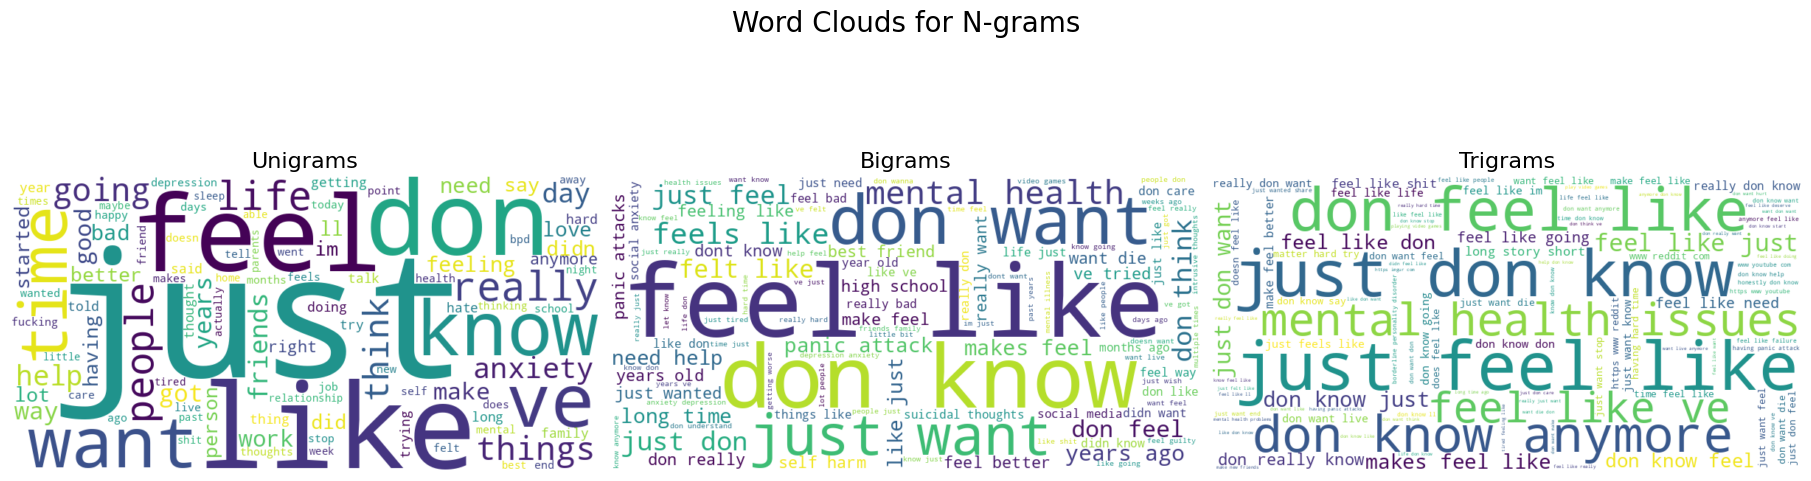

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the WordCloud objects for unigrams, bigrams, and trigrams
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigrams)
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigrams)
wordcloud3 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigrams)

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Plot each word cloud on its respective subplot
axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Unigrams', fontsize=16)

axes[1].imshow(wordcloud2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Bigrams', fontsize=16)

axes[2].imshow(wordcloud3, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title('Trigrams', fontsize=16)

# Show the figure
plt.suptitle('Word Clouds for N-grams', fontsize=20)
plt.show()


### 3.5 Visualization of Preprocessed text

In [ ]:
#We first fill the NA values in the column 'lemmatization_noun_adj'
df_preprocessing['lemmatization_noun_adj'] = df_preprocessing['lemmatization_noun_adj'].fillna('')
unigrams_preprocessed =bow_most_common(data = df_preprocessing['lemmatization_noun_adj'], ngram=1)
bigrams_preprocessed = bow_most_common(data=df_preprocessing['lemmatization_noun_adj'], ngram=2)
trigrams_preprocessed = bow_most_common(data=df_preprocessing['lemmatization_noun_adj'], ngram=3)

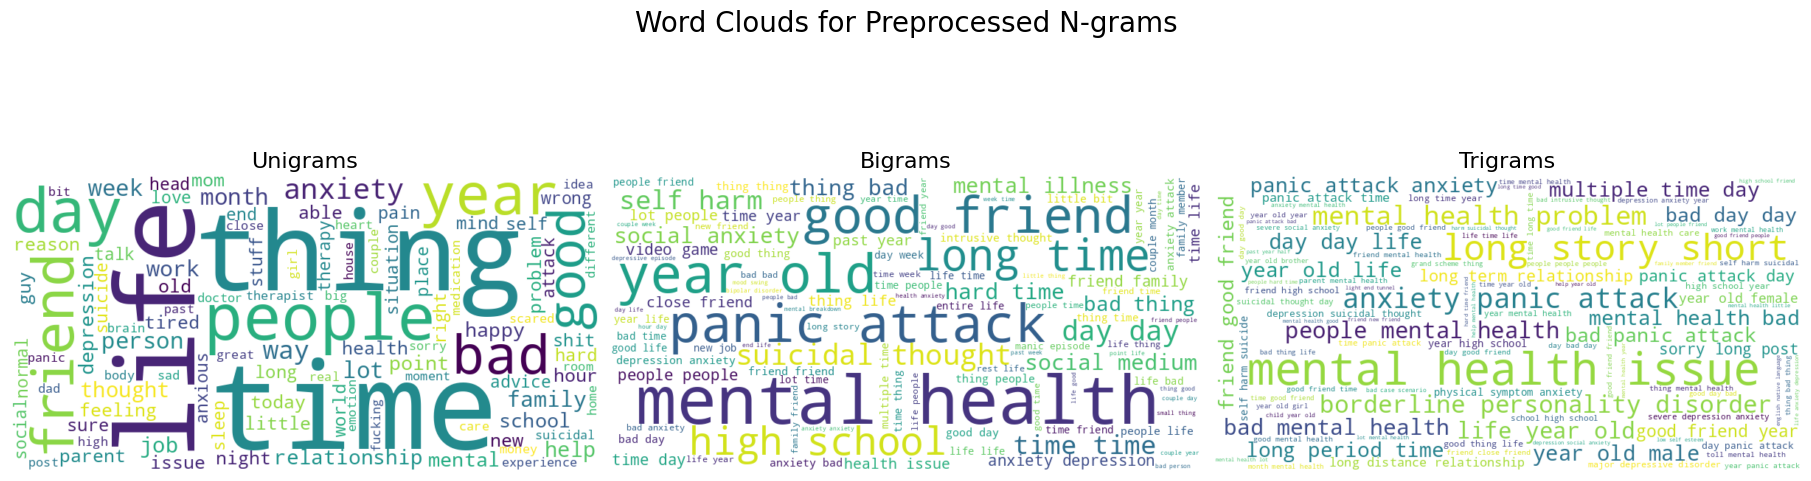

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the WordCloud objects for unigrams, bigrams, and trigrams
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigrams_preprocessed)
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigrams_preprocessed)
wordcloud3 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigrams_preprocessed)

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Plot each word cloud on its respective subplot
axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Unigrams', fontsize=16)

axes[1].imshow(wordcloud2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Bigrams', fontsize=16)

axes[2].imshow(wordcloud3, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title('Trigrams', fontsize=16)

# Show the figure
plt.suptitle('Word Clouds for Preprocessed N-grams', fontsize=20)
plt.show()


### 3.6 Specific subreddit -- SuicideWatch

In [ ]:
# Original text
data_suicide_watch = df_preprocessing[df_preprocessing['subreddit']=='SuicideWatch']['full_text']

In [ ]:
unigram_suicidal = bow_most_common(data=data_suicide_watch, ngram=1)
bigram_suicial = bow_most_common(data=data_suicide_watch, ngram=2)
trigram_suicial = bow_most_common(data=data_suicide_watch, ngram=3)

In [ ]:
# Preprocessed text
data_suicide_watch = df_preprocessing[df_preprocessing['subreddit']=='SuicideWatch']['lemmatization_noun_adj']
unigram_preprocessed_suicidal = bow_most_common(data=data_suicide_watch, ngram=1)
bigram_preprocessed_suicidal = bow_most_common(data=data_suicide_watch, ngram=2)
trigram_preprocessed_suicidal = bow_most_common(data=data_suicide_watch, ngram=3)

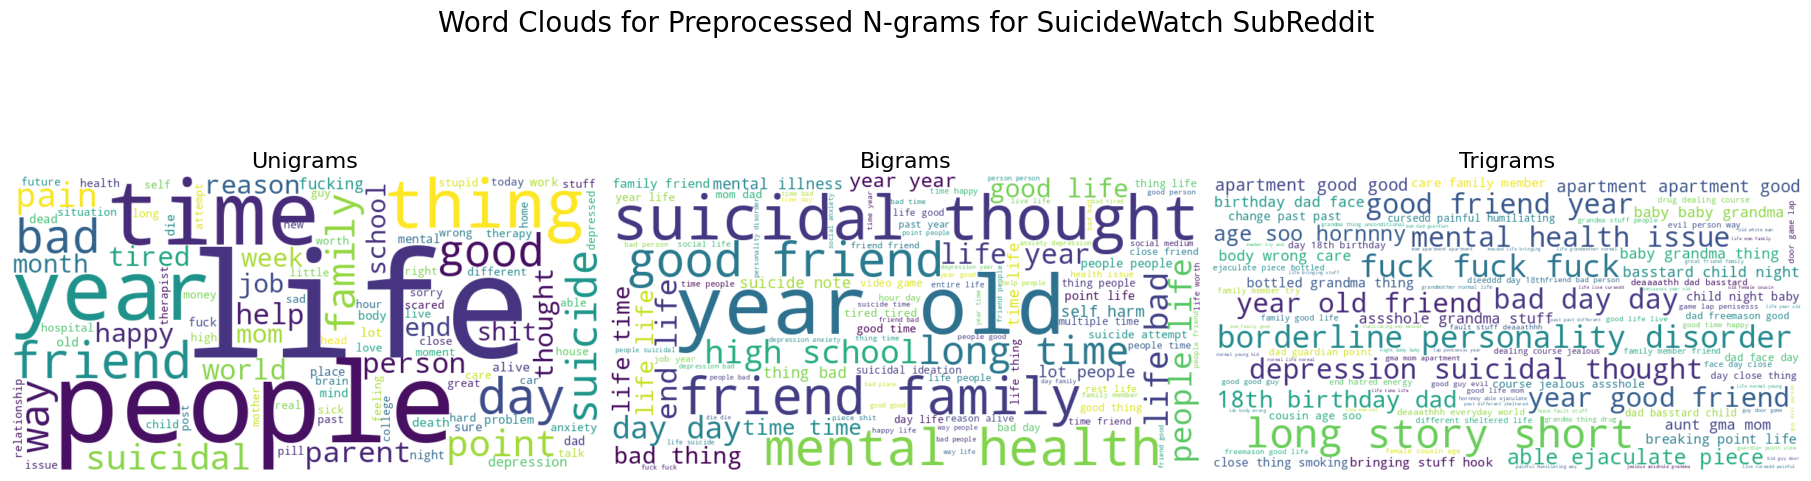

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the WordCloud objects for unigrams, bigrams, and trigrams
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigram_preprocessed_suicidal)
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_preprocessed_suicidal)
wordcloud3 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_preprocessed_suicidal)

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Plot each word cloud on its respective subplot
axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Unigrams', fontsize=16)

axes[1].imshow(wordcloud2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Bigrams', fontsize=16)

axes[2].imshow(wordcloud3, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title('Trigrams', fontsize=16)

# Show the figure
plt.suptitle('Word Clouds for Preprocessed N-grams for SuicideWatch SubReddit', fontsize=20)
plt.show()


### 3.7 TF-IDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

def tfidf_score(data, result=False):
    tfidf = TfidfVectorizer(
        analyzer='word',
        min_df=0.001,
        max_df=0.75,
        stop_words='english',
        sublinear_tf=True
    )

    X_tfidf = tfidf.fit_transform(data)

    bow = CountVectorizer(
        analyzer='word',
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    X_bow = bow.fit_transform(data)

    words = pd.DataFrame(
        data={
            'word': bow.get_feature_names_out(),
            'tf': X_bow.sum(axis=0).A1,
            'idf': tfidf.idf_,
            'tfidf': X_tfidf.sum(axis=0).A1
        }
    ).sort_values(['tfidf', 'tf', 'idf'], ascending=False).reset_index(drop=True)

    if result:
        return words

    print('Words with highest TF-IDF score')
    print()
    print(words.head(10))
    print()
    print('Words with lowest TF-IDF score')
    print()
    print(words.tail(10))


In [ ]:
tfidf_score(data=df_preprocessing['full_text'])


Words with highest TF-IDF score

     word    tf       idf       tfidf
0    just  9132  1.496365  248.309559
1    like  7843  1.589322  225.186726
2    feel  6154  1.765409  210.771047
3     don  6023  1.784961  202.747297
4    want  4089  2.011309  175.408830
5    know  4719  1.872405  172.972850
6      ve  4407  1.995389  165.345236
7    life  3410  2.180241  150.583065
8  really  3491  2.144513  145.266222
9  people  3316  2.227485  141.590639

Words with lowest TF-IDF score

               word  tf       idf     tfidf
5609      summarize   6  7.752938  0.621865
5610       gorgeous   6  7.752938  0.616453
5611  consideration   6  7.752938  0.609517
5612    unknowingly   6  7.752938  0.607130
5613    transparent   6  7.752938  0.575454
5614     pedophilia   6  7.752938  0.554672
5615        remarks   6  7.752938  0.541486
5616    socialising   6  7.752938  0.534423
5617        disdain   6  7.752938  0.521466
5618         tables   6  7.752938  0.520355


In [ ]:
# TF-IDF Score of preprocessed texts
tfidf_score(data=df_preprocessing['lemmatization_noun_adj'])

Words with highest TF-IDF score

      word    tf       idf       tfidf
0     time  4241  1.951251  225.145575
1     life  3388  2.178613  217.044540
2   people  3296  2.230335  204.725487
3    thing  3441  2.153987  197.333054
4      day  3030  2.227485  189.268116
5   friend  2615  2.471912  174.807011
6      bad  2336  2.388966  172.310998
7     year  2760  2.289106  171.018823
8  anxiety  2032  2.683135  166.064394
9     good  2141  2.436219  156.326414

Words with lowest TF-IDF score

               word  tf       idf     tfidf
2921       profound   7  7.752938  0.934520
2922        measure   6  7.752938  0.934322
2923        trapped   6  7.752938  0.922498
2924         errand   6  7.752938  0.911449
2925       gorgeous   6  7.752938  0.908501
2926  consideration   6  7.752938  0.871117
2927    transparent   6  7.752938  0.823814
2928          candy   6  7.752938  0.818066
2929          niche   6  7.752938  0.817960
2930      paragraph   7  7.752938  0.772931


In [ ]:
# Preprocessed text, divided by subreddit

for subreddit in list(set(df_preprocessing['subreddit'])):
    print('---- ', subreddit, ' ----')
    print()
    tfidf_score(data=df_preprocessing[df_preprocessing['subreddit']==subreddit]['lemmatization_noun_adj'])
    print()

----  mentalhealth  ----

Words with highest TF-IDF score

     word   tf       idf      tfidf
0    time  959  1.764456  37.850944
1   thing  805  1.939845  34.016908
2  people  653  2.114939  32.451302
3    life  592  2.143110  31.946929
4     day  666  2.078572  31.280785
5     bad  553  2.099625  31.207460
6  friend  600  2.246708  29.641582
7    year  595  2.096590  28.999550
8  mental  411  2.323529  27.879961
9    good  422  2.327338  24.607080

Words with lowest TF-IDF score

              word  tf       idf    tfidf
5510          teeh   1  7.202536  0.05133
5511   temperature   1  7.202536  0.05133
5512  thunderstorm   1  7.202536  0.05133
5513          ting   1  7.202536  0.05133
5514         tonbe   1  7.202536  0.05133
5515           tor   1  7.202536  0.05133
5516     vegetabel   1  7.202536  0.05133
5517           wit   1  7.202536  0.05133
5518           wnd   1  7.202536  0.05133
5519       yelling   1  7.202536  0.05133

----  SuicideWatch  ----

Words with highest TF-I

In [ ]:
# A better approach
document_list = []

for subreddit in list(set(df_preprocessing['subreddit'])):
    document_list.append(' '.join(df_preprocessing[df_preprocessing['subreddit']==subreddit]['lemmatization_noun_adj']))

tfidf_score(data=document_list)

Words with highest TF-IDF score

         word   tf       idf     tfidf
0       manic  176  1.287682  0.222180
1   worthless  100  1.287682  0.182379
2        ward   39  1.287682  0.157920
3  meaningful   45  1.287682  0.147496
4   inpatient   27  1.287682  0.144305
5      dosage   33  1.287682  0.143787
6  loneliness   45  1.287682  0.142789
7         gun   57  1.287682  0.141230
8   available   36  1.287682  0.140074
9   pointless   50  1.287682  0.139895

Words with lowest TF-IDF score

           word  tf       idf     tfidf
11065      xbox   1  2.386294  0.015404
11066   yelling   1  2.386294  0.015404
11067      ymca   1  2.386294  0.015404
11068     youdo   1  2.386294  0.015404
11069  youngbut   1  2.386294  0.015404
11070      youu   1  2.386294  0.015404
11071      zero   1  2.386294  0.015404
11072    zitter   1  2.386294  0.015404
11073      zwie   1  2.386294  0.015404
11074   zyprexa   1  2.386294  0.015404


In [ ]:
# Particular category of subreddits
document_list = []

for subreddit in list(set(df_preprocessing['subreddit'])):

    if subreddit in ['CasualConversation', 'mentalhealth']:
        pass

    document_list.append(' '.join(df_preprocessing[df_preprocessing['subreddit']==subreddit]['lemmatization_noun_adj']))

tfidf_score(data=document_list)

Words with highest TF-IDF score

         word   tf       idf     tfidf
0       manic  176  1.287682  0.222180
1   worthless  100  1.287682  0.182379
2        ward   39  1.287682  0.157920
3  meaningful   45  1.287682  0.147496
4   inpatient   27  1.287682  0.144305
5      dosage   33  1.287682  0.143787
6  loneliness   45  1.287682  0.142789
7         gun   57  1.287682  0.141230
8   available   36  1.287682  0.140074
9   pointless   50  1.287682  0.139895

Words with lowest TF-IDF score

           word  tf       idf     tfidf
11065      xbox   1  2.386294  0.015404
11066   yelling   1  2.386294  0.015404
11067      ymca   1  2.386294  0.015404
11068     youdo   1  2.386294  0.015404
11069  youngbut   1  2.386294  0.015404
11070      youu   1  2.386294  0.015404
11071      zero   1  2.386294  0.015404
11072    zitter   1  2.386294  0.015404
11073      zwie   1  2.386294  0.015404
11074   zyprexa   1  2.386294  0.015404


### 3.8 Word Embeddings + Dimensionality Reduction

In [ ]:
from gensim.models import Word2Vec

corpus = df_preprocessing['lemmatization_noun_adj'].apply(lambda x: x.split()).tolist()

w2v_model = Word2Vec(
    vector_size=100,   # Output vector dimensionality
    window=15,         # Context window size
    sample=0.0001,     # Down-sampling frequent words
    epochs=200,        # Number of training epochs
    negative=5,        # Number of negative sampling
    min_count=100,     # Minimum count threshold for words
    workers=-1,        # Utilize all available CPU cores
    sg=0,              # Use CBOW model
    hs=0               # Hierarchical softmax is disabled
)

w2v_model.build_vocab(corpus)

w2v_model.train(
    corpus,                          # Input tokenized corpus
    total_examples=w2v_model.corpus_count,  # Total number of training sentences
    epochs=w2v_model.epochs          # Number of training epochs
)


(0, 0)

In [ ]:
# Find and display the most similar words to a given word based on the trained Word2Vec model

# Define the target word and the number of similar words to display
target_word = 'suicide'
top_n_similar = 10

# Retrieve the most similar words using the Word2Vec model's vocabulary
similar_words = w2v_model.wv.most_similar(target_word, topn=top_n_similar)

print(f"Top {top_n_similar} words most similar to '{target_word}':")
for word, similarity in similar_words:
    print(f"{word}: {similarity:.4f}")


Top 10 words most similar to 'suicide':
life: 0.3698
week: 0.3145
fault: 0.3033
bpd: 0.2820
year: 0.2795
message: 0.2742
amount: 0.2699
talk: 0.2568
help: 0.2555
contact: 0.2535


In [ ]:
# Calculate and display the cosine similarity between two words
# This measures how closely related the two words are based on the trained Word2Vec embeddings

word1 = 'depression'
word2 = 'anxiety'

# Computing the cosine similarity between the two words using the Word2Vec model
similarity_score = w2v_model.wv.similarity(word1, word2)

# Print the words and their similarity score
print(f"Cosine similarity between '{word1}' and '{word2}': {similarity_score:.4f}")


Cosine similarity between 'depression' and 'anxiety': 0.0151


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("leadbest/googlenewsvectorsnegative300")

print("Path to dataset files:", path)

100%|██████████| 3.17G/3.17G [00:43<00:00, 78.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/leadbest/googlenewsvectorsnegative300/versions/2


In [ ]:
from gensim.models import KeyedVectors
import os

# Construct the full path to the `.bin` file
bin_file = os.path.join(path, "GoogleNews-vectors-negative300.bin")

# Load the pre-trained Word2Vec model
pretrained_model = KeyedVectors.load_word2vec_format(bin_file, binary=True)

# Compute similarity between two words
similarity = pretrained_model.similarity('depression', 'anxiety')
print("Similarity between 'depression' and 'anxiety':", similarity)


Similarity between 'depression' and 'anxiety': 0.5102126


### 3.9 Vectorize text data, reduce its dimensionality for visualization, and plot the results.

In [ ]:
def vectorize(df, model):

    list_of_docs = df.apply(lambda x: x.split()).to_list()

    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)

    return np.array(features)

vectorized_docs = vectorize(df_preprocessing['lemmatization_noun_adj'], model=pretrained_model)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

sb.set_context('notebook')

def plot_vectors(vectors, title, labels=None):

    fig = plt.figure(figsize=(10,10))

    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})

    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)


    # Random colors for better visualization
    n_labels = len(df.label.unique())
    label_colors = []
    for l in range(n_labels):
        label_colors.append(list(np.random.rand(4,)))

    cMap = colors.ListedColormap(label_colors)

    ax = fig.add_subplot(111)
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

    for l, label in enumerate(df.label.unique()):
        df2 = df[df.label == label]
        color_values = [label_colors[l]] * len(df2)
        ax.scatter(df2['x'], df2['y'],
                   c=color_values,
                   cmap=cMap,
                   edgecolor='black',
                   label=label,
                   alpha=0.4,
                   s=100)

    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
from sklearn.decomposition import TruncatedSVD

def reduce_and_plot(df, labels, title, sample=False, model=pretrained_model):

    docs = vectorize(df, model)

    svd = TruncatedSVD(n_components=2)
    docs_reduced = svd.fit_transform(docs)

    stack = np.hstack((docs_reduced, labels.to_numpy().reshape(-1,1)))

    if sample:
        stack = stack[np.random.randint(stack.shape[0], size=300), :]

    plot_vectors(stack[:, [0,1]], labels=stack[:, 2], title=title)

### BINARY LABELLING: normal vs. mental health related post

In [ ]:
def binary_label(text):
    if text == 'CasualConversation':
        return 0
    return 1

binary_labels = df_preprocessing.subreddit.apply(lambda x: binary_label(x))

<ipython-input-90-6564dbc1a0d7>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df2['x'], df2['y'],


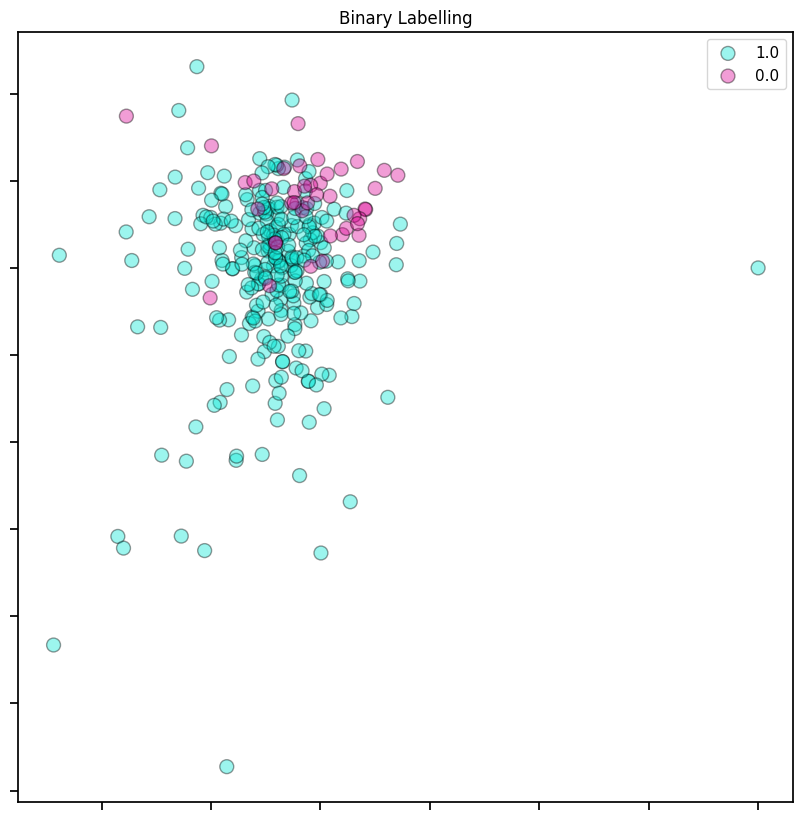

In [ ]:
# Using the whole dataset
from matplotlib import colors

reduce_and_plot(df=df_preprocessing['lemmatization_noun_adj'], labels=binary_labels, title='Binary Labelling',sample=True)

### PROBLEM SPECIFIC: anxiety vs. depression vs. suicide

In [ ]:
problem_specific = df_preprocessing[df_preprocessing['subreddit'].isin(['Anxiety', 'depression', 'SuicideWatch'])]

<ipython-input-90-6564dbc1a0d7>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df2['x'], df2['y'],


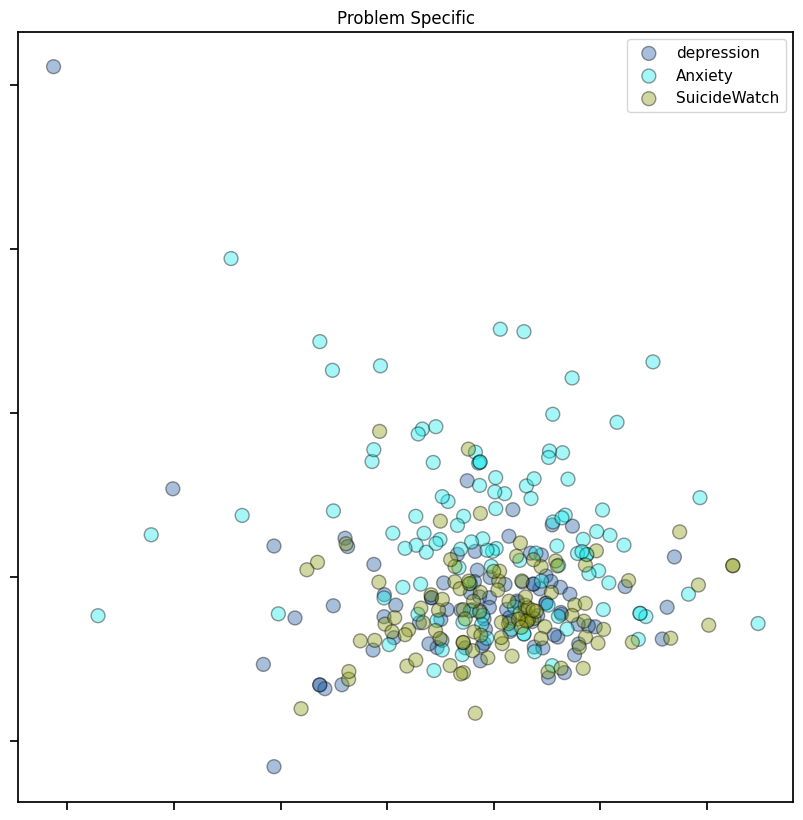

In [ ]:
# Using a random sample of the data

reduce_and_plot(df=problem_specific['lemmatization_noun_adj'], labels=problem_specific.subreddit, title='Problem Specific',sample=True)

<ipython-input-90-6564dbc1a0d7>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df2['x'], df2['y'],


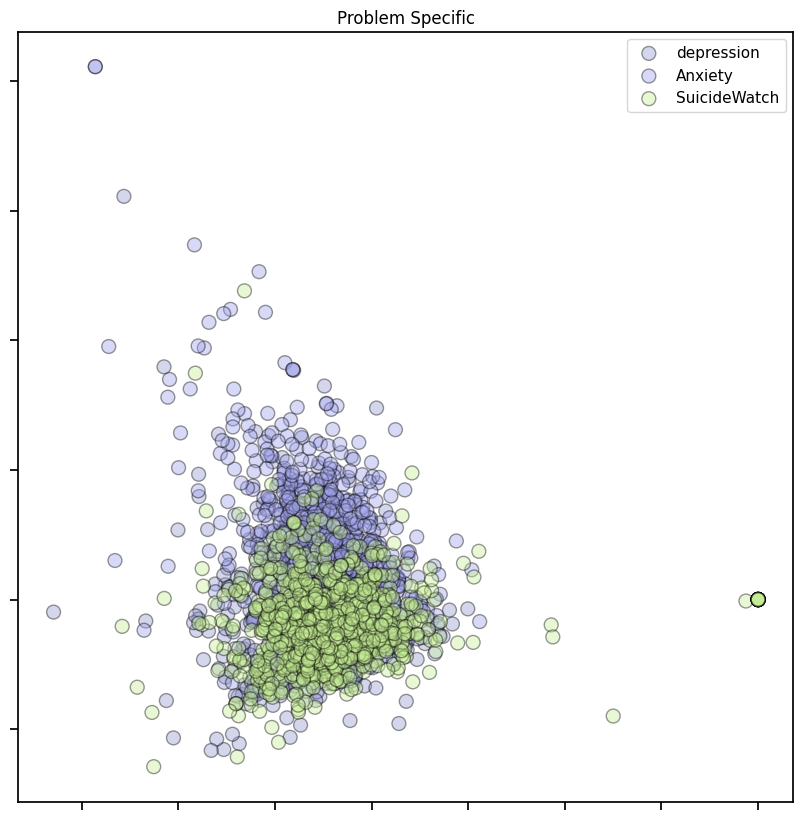

In [ ]:
# Using the whole dataset

reduce_and_plot(df=problem_specific['lemmatization_noun_adj'], labels=problem_specific.subreddit, title='Problem Specific')

### 3.10 Author Topic Modelling

In [ ]:
from gensim.models import AuthorTopicModel
from gensim.test.utils import datapath, temporary_file
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
# Tokenize the text into a list of words
tokenized_instances = df_preprocessing['lemmatization_noun_adj'].apply(lambda x: x.split()).tolist()

# Identify common phrases (bigrams or trigrams) in the text data
common_phrases = Phrases(tokenized_instances, min_count=5, threshold=1)
tokenized_with_phrases = common_phrases[tokenized_instances]

# Create a dictionary representation of the text data
word_dictionary = Dictionary(tokenized_with_phrases)

# Filter the dictionary to retain words appearing in at least 50 documents and in no more than 30% of the documents
word_dictionary.filter_extremes(no_below=50, no_above=0.3)
print(word_dictionary, flush=True)

# Convert the text data into a bag-of-words (BoW) corpus
bow_corpus = [word_dictionary.doc2bow(doc) for doc in tokenized_instances]

# Build a TF-IDF model and transform the BoW corpus
tfidf_model = TfidfModel(bow_corpus)
transformed_corpus = tfidf_model[bow_corpus]


Dictionary<681 unique tokens: ['annoying', 'decision', 'future', 'help', 'love']...>


In [ ]:
from collections import defaultdict

# Group document indices by subreddit
subreddit_to_docs = defaultdict(list)

for index, subreddit_name in enumerate(df_preprocessing['subreddit']):
    subreddit_to_docs[subreddit_name].append(index)

# Get the total number of unique subreddits
num_unique_subreddits = len(subreddit_to_docs)
print('Number of unique subreddits in the dataset:',num_unique_subreddits)
print('Length of the Bag of Words:',len(bow_corpus))


Number of unique subreddits in the dataset: 7
Length of the Bag of Words: 5995


In [ ]:
# Initialize lists to store coherence values and models
coherence_scores = []
subreddit_model_list = []

# Define the size of the development corpus
dev_corpus_size = len(bow_corpus)

# Filter documents for development set based on indices
dev_subreddit_to_docs = {key: [idx for idx in value if idx < dev_corpus_size] for key, value in subreddit_to_docs.items()}

# Iterate through the range of topics to build and evaluate models
for topic_count in range(5, 11):
    subreddit_model = AuthorTopicModel(
        corpus=list(bow_corpus[:dev_corpus_size]),
        author2doc=dev_subreddit_to_docs,
        id2word=word_dictionary,
        num_topics=topic_count,
        alpha=0.5,
        random_state=42
    )

    # Calculate coherence using u_mass
    coherence_model_umass = CoherenceModel(
        model=subreddit_model,
        texts=tokenized_instances[:dev_corpus_size],
        dictionary=word_dictionary,
        coherence='u_mass'
    )

    # Calculate coherence using c_v
    coherence_model_cv = CoherenceModel(
        model=subreddit_model,
        texts=tokenized_instances[:dev_corpus_size],
        dictionary=word_dictionary,
        coherence='c_v'
    )

    umass_score = coherence_model_umass.get_coherence()
    cv_score = coherence_model_cv.get_coherence()

    print(topic_count, umass_score, cv_score)
    coherence_scores.append((topic_count, umass_score, cv_score))


5 -1.6051591544113712 0.4064760522090026


6 -1.6203310902361272 0.41050235001161


7 -1.6700266354049025 0.4109194898648965


8 -1.6552973064862955 0.4114857387604204


9 -1.7120829970974063 0.40085278532487323


10 -1.6783381557065777 0.4060715239593936


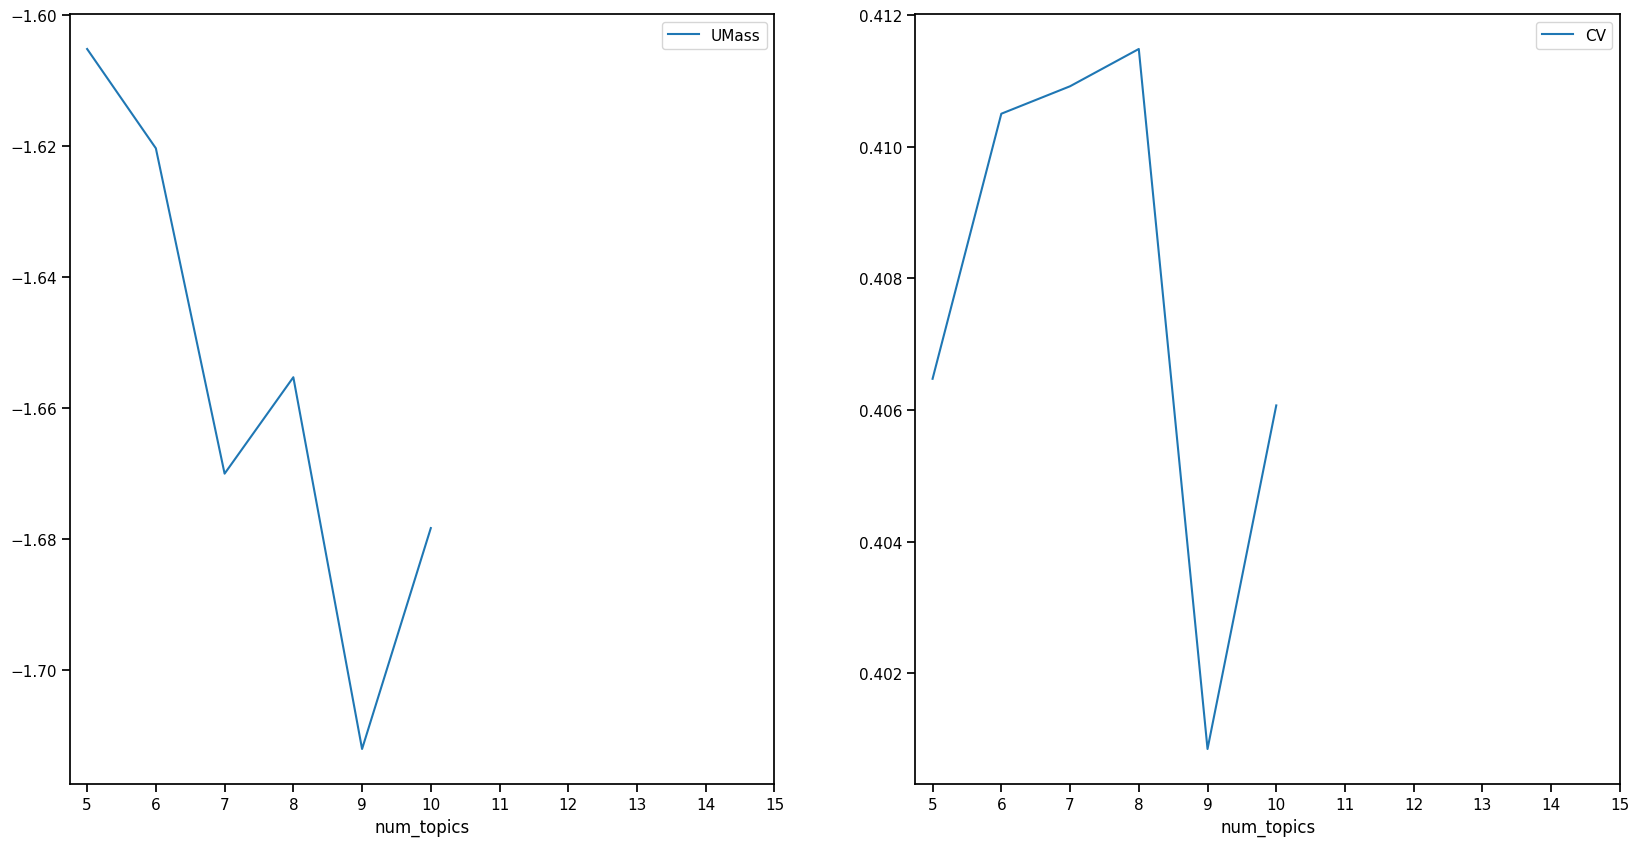

In [ ]:
%matplotlib inline
scores = pd.DataFrame(coherence_scores, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));

In [ ]:
# Define parameters for the AuthorTopicModel
num_topics_for_authors = 8
num_training_passes = 10
chunk_size_value = len(transformed_corpus) * num_training_passes / 200

# Create the AuthorTopicModel
subreddit_model = AuthorTopicModel(
    corpus=list(bow_corpus),
    author2doc=subreddit_to_docs,
    id2word=word_dictionary,
    num_topics=num_topics_for_authors,
    passes=num_training_passes,
    chunksize=chunk_size_value,
    alpha=0.5,
    random_state=0
)


In [ ]:
import re

topic_sep = re.compile("0\.[0-9]{3}\*")

subreddit_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                subreddit_model.print_topics(num_topics=num_topics_for_authors, num_words=10)]

author_descriptors = []
for i, m in sorted(subreddit_model_topics):
    print(i+1, ", ".join(m[:10]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "friend", "school", "funny", "weird", "year", "class", "student", "body", "good", "college"
2 "life", "people", "suicide", "world", "point", "suicidal", "tired", "shit", "pain", "reason"
3 "job", "day", "work", "good", "happy", "hour", "new", "food", "game", "proud"
4 "time", "people", "good", "friend", "year", "thing", "way", "first", "guy", "day"
5 "week", "time", "month", "episode", "bad", "disorder", "experience", "day", "medication", "health"
6 "year", "mom", "parent", "family", "old", "dad", "mother", "kid", "child", "money"
7 "anxiety", "anxious", "attack", "panic", "bad", "heart", "day", "stomach", "chest", "advice"
8 "thing", "time", "bad", "relationship", "person", "people", "friend", "day", "life", "way"


Based on the words that make up the topics, we can try to find the common denominator with some intuition after reading a lot of posts:

1. Talk about the past or about a story
2. Talk about depression and its causes/consequences
3. Talk about anxiety and its causes/consequences
4. Talk about therapy and medication: what people are doing and what is the progress
5. General conversational topics (positive-ish)
6. Talk over phone/internet
7. Physical symptoms
8. General conversational topics (negative-ish)

In [ ]:
# Initialize mapping from covariate(=author/country) to topic distro, set all to 0.0

author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(subreddit_model.num_topics)}
              for author in subreddit_model.id2author.values()}


for author in subreddit_model.id2author.values():
    for (t, v) in subreddit_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v


target_countries = list(set(df_preprocessing['subreddit']))

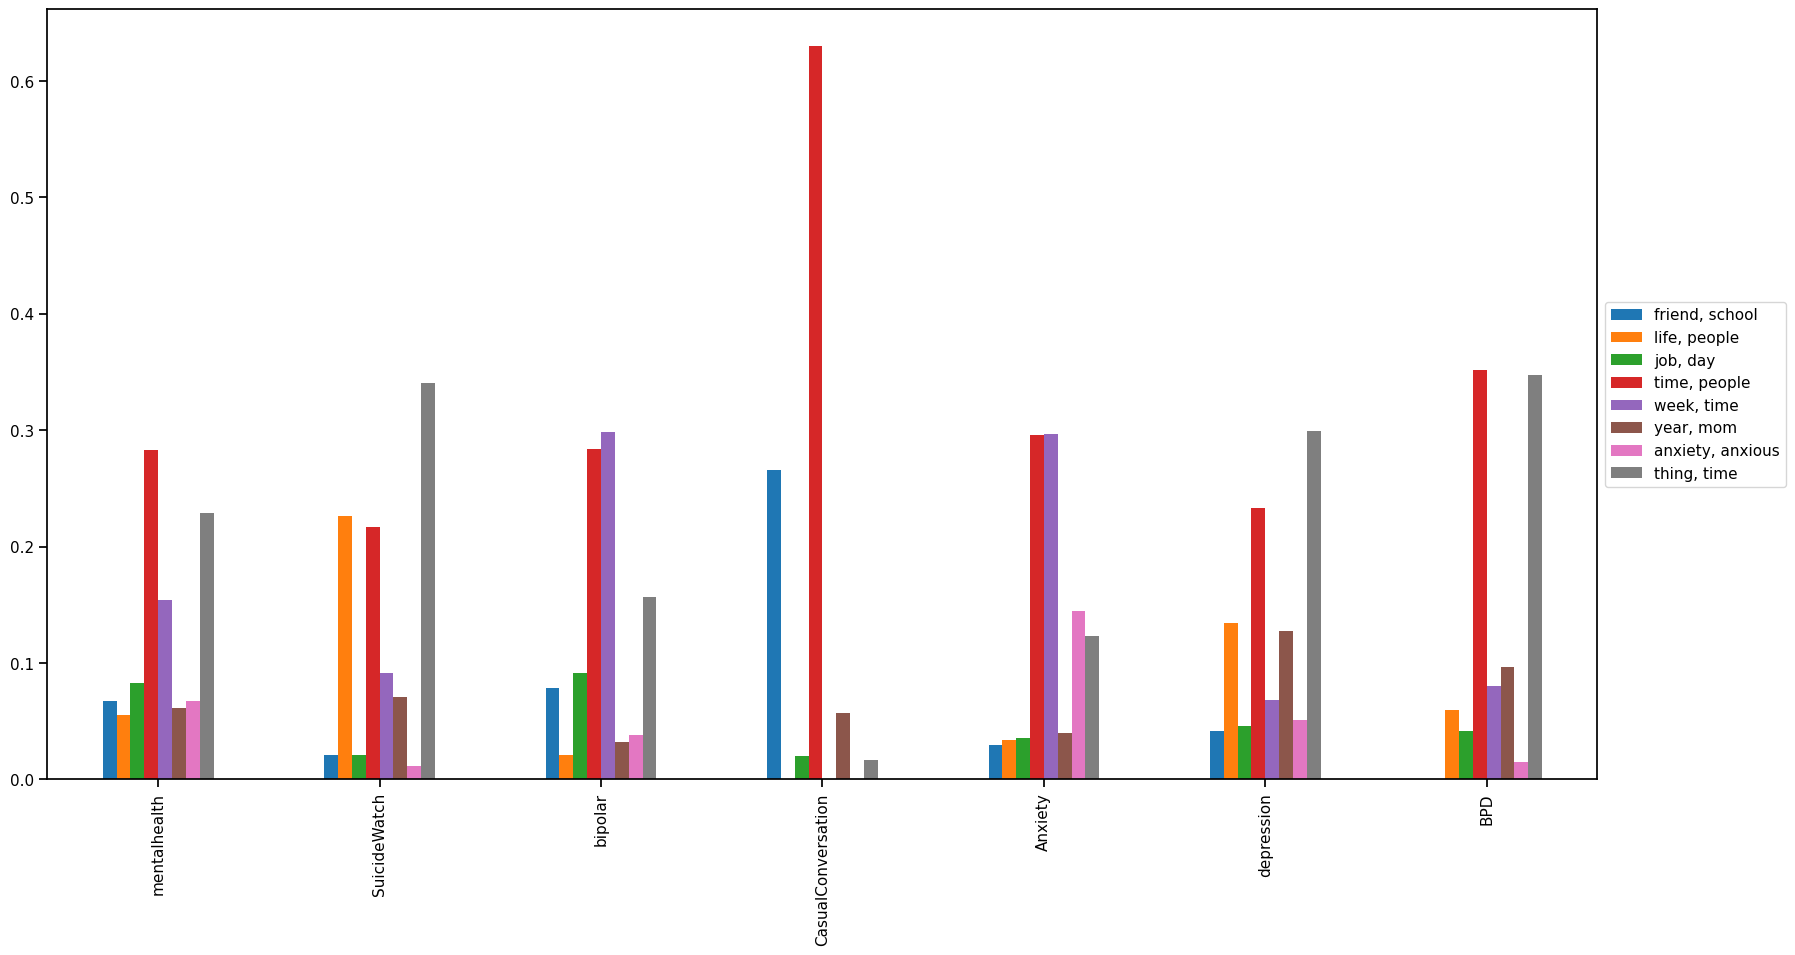

In [ ]:
author_df = pd.DataFrame.from_dict(author_vecs)


fig, ax = plt.subplots(figsize=(20,10))
author_df[target_countries].T.plot.bar(ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

### 3.11 Sentiment Analysis

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def compute_polarity_score(text):
    return sid.polarity_scores(text)['compound']

In [ ]:
df_preprocessing['full_text_score'] = df_preprocessing['full_text'].apply(lambda x: compute_polarity_score(x))

In [ ]:
# Average sentiment per subreddit

df_preprocessing['full_text_score'] = pd.to_numeric(df_preprocessing['full_text_score'], errors='coerce')
mean_sentiment_per_subreddit = df_preprocessing.groupby('subreddit')['full_text_score'].mean()
print(mean_sentiment_per_subreddit)


subreddit
Anxiety              -0.300415
BPD                  -0.165735
CasualConversation    0.464521
SuicideWatch         -0.456508
bipolar              -0.122982
depression           -0.331703
mentalhealth         -0.218340
Name: full_text_score, dtype: float64


<Axes: ylabel='Frequency'>

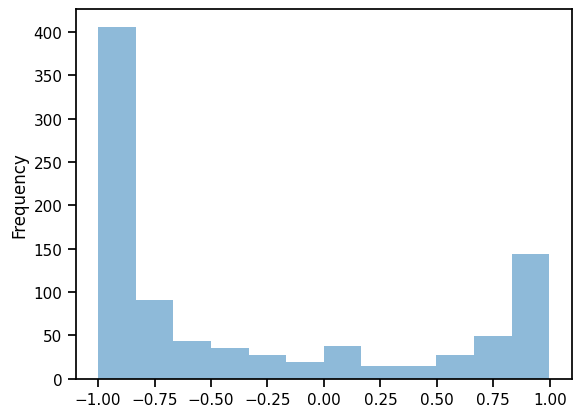

In [ ]:
df_preprocessing[df_preprocessing['subreddit']=='depression']['full_text_score'].plot.hist(bins=12, alpha=0.5)

<Axes: ylabel='Frequency'>

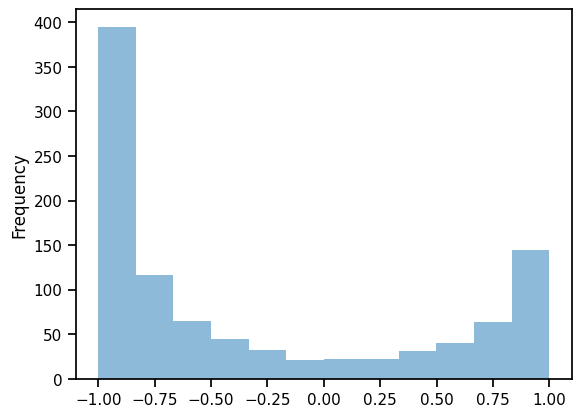

In [ ]:
df_preprocessing[df_preprocessing['subreddit']=='Anxiety']['full_text_score'].plot.hist(bins=12, alpha=0.5)

<Axes: ylabel='Frequency'>

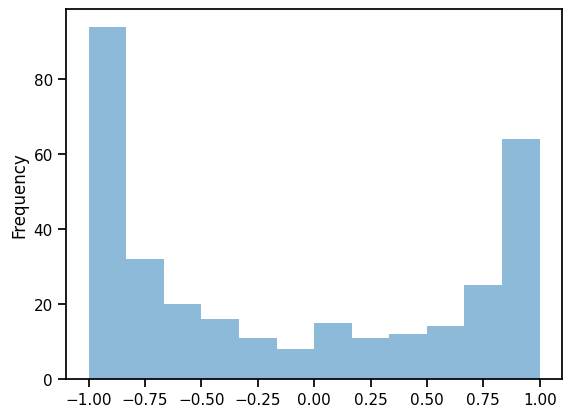

In [ ]:
df_preprocessing[df_preprocessing['subreddit']=='bipolar']['full_text_score'].plot.hist(bins=12, alpha=0.5)

<Axes: ylabel='Frequency'>

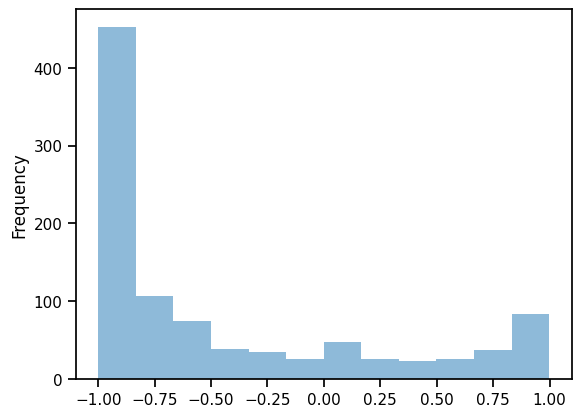

In [ ]:
df_preprocessing[df_preprocessing['subreddit']=='SuicideWatch']['full_text_score'].plot.hist(bins=12, alpha=0.5)

<Axes: ylabel='Frequency'>

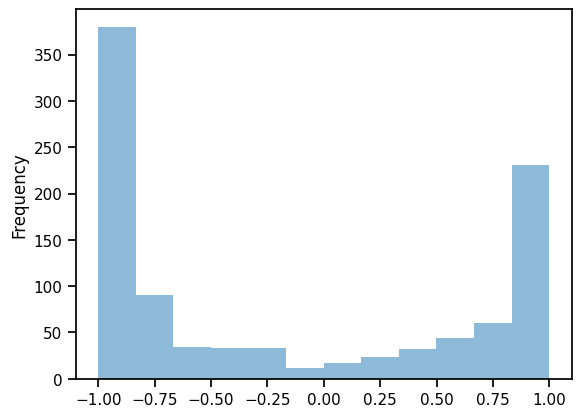

In [ ]:
df_preprocessing[df_preprocessing['subreddit']=='BPD']['full_text_score'].plot.hist(bins=12, alpha=0.5)

<Axes: ylabel='Frequency'>

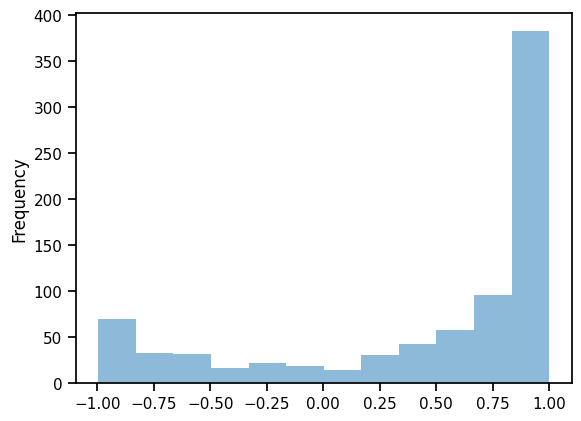

In [ ]:
df_preprocessing[df_preprocessing['subreddit']=='CasualConversation']['full_text_score'].plot.hist(bins=12, alpha=0.5)

The sentiment of r/CasualConversation is definetely skewed towards the positive spectrum. <br>
Without surprise, r/SuicideWatch has the distribution most skewed toward the negative spectrum. <br>

What is interesting is that r/bipolar and r/BPD show more "even" distributions. <br>
This is in line with the specific conditions, which tend to have both highs and lows.

## 4. Model Development
### 4.1 Baseline Models
- Most Frequent Label Classifier
- Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split

### Most-frequent-label Classifier

In [ ]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

def baseline_majority_classifier(train_features, dev_features, train_labels, dev_labels, return_predictions=False):
    """
    A baseline classifier that always predicts the most frequent class in the training data.
    """
    # Initialize and train the classifier
    majority_classifier = DummyClassifier(strategy='most_frequent')
    majority_classifier.fit(train_features, train_labels)

    # Make predictions on the development set
    predicted_labels = majority_classifier.predict(dev_features)

    # Print the classification report
    print(classification_report(dev_labels, predicted_labels))

    # Optionally return the predictions
    if return_predictions:
        return predicted_labels


### Logistic Regression with TF-IDF at post-level

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def char_ngrams_tfidf_vectorizer(train_data, dev_data, test_data):
    """
    Applies TF-IDF vectorization on character-level n-grams for train, dev, and test datasets.
    """
    # Configure the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(2, 6),
        min_df=0.001,
        max_df=0.7,
        analyzer='char',
        sublinear_tf=True
    )

    # Fit on the training data and transform all datasets
    train_features = tfidf_vectorizer.fit_transform(train_data)
    dev_features = tfidf_vectorizer.transform(dev_data)
    test_features = tfidf_vectorizer.transform(test_data)

    return train_features, dev_features, test_features


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def train_and_evaluate(train_data, dev_data, train_labels, dev_labels, custom_model=None, return_predictions=False):
    """
    Train a classifier and evaluate its performance on the development set.
    """
    # Use a default logistic regression model if no model is provided
    model = custom_model or LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs')

    # Train the model on the training data
    model.fit(train_data, train_labels)

    # Predict on the development data
    dev_predictions = model.predict(dev_data)

    # Print the classification report
    print(classification_report(dev_labels, dev_predictions))

    # Optionally return the predictions
    if return_predictions:
        return dev_predictions


### Logistic Regression with TF-IDF at document-level

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_documents_by_subreddit(train_data, train_labels, dev_data, test_data):
    """
    Vectorizes documents by subreddit using character-level n-grams with TF-IDF.
    """
    # Merge the training data and labels
    merged_train = pd.merge(train_data, train_labels, left_index=True, right_index=True)

    # Create a list of documents for each subreddit
    subreddit_documents = []
    for subreddit in merged_train['subreddit'].unique():
        combined_doc = ' '.join(merged_train[merged_train['subreddit'] == subreddit]['lemmatization_noun_adj'])
        subreddit_documents.append(combined_doc)

    # Initialize the TF-IDF vectorizer with specified parameters
    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(2, 6),
        min_df=0.001,
        max_df=0.7,
        analyzer='char',
        sublinear_tf=True
    )

    # Fit the vectorizer on the subreddit-based documents
    tfidf_vectorizer.fit(subreddit_documents)

    # Transform the training, development, and test data using the vectorizer
    train_vectorized = tfidf_vectorizer.transform(train_data)
    dev_vectorized = tfidf_vectorizer.transform(dev_data)
    test_vectorized = tfidf_vectorizer.transform(test_data)

    return train_vectorized, dev_vectorized, test_vectorized


### Reduced labels


In [ ]:
df_reduced = df_preprocessing[df_preprocessing['subreddit'].isin(['depression', 'Anxiety', 'CasualConversation', 'SuicideWatch'])]

In [ ]:
df_reduced =  df_reduced.drop(df_reduced.columns[0], axis=1)
df_reduced.head()

,url,full_text,step_01_reddit_cleanup,step_02_remove_stopwords,step_03_remove_punctuation,lemmatization_standard,lemmatization_noun_adj,subreddit,full_text_score
987,https://www.reddit.com/r/depression/comments/d...,Our most-broken and least-understood rules is ...,Our most-broken and least-understood rules is ...,"Our most-broken least-understood rules ""helper...",Our mostbroken leastunderstood rules helpers m...,our mostbroken leastunderstood rule helper may...,mostbroken leastunderstood helper private cont...,depression,0.9959
988,https://www.reddit.com/r/depression/comments/m...,"Regular Check-In Post, with important reminder...","Regular Check-In Post, with important reminder...","Regular Check-In Post, important reminders No ...",Regular CheckIn Post important reminders No Pr...,regular CheckIn Post important reminder no pri...,regular important reminder private contact act...,depression,0.9254
989,https://www.reddit.com/r/depression/comments/n...,Real depression Everyone wants to say they hav...,Real depression Everyone wants to say they hav...,Real depression Everyone wants say depression....,Real depression Everyone wants say depression ...,real depression everyone want say depression r...,real depression depression real depression rea...,depression,-0.9432
990,https://www.reddit.com/r/depression/comments/n...,Mother passed away today \n\nToday this morn...,Mother passed away today Today this morning my...,Mother passed away today Today morning mother ...,Mother passed away today Today morning mother ...,Mother pass away today today morning mother pa...,today today morning mother painful colon cance...,depression,0.9708
991,https://www.reddit.com/r/depression/comments/n...,"Waking up every morning with thoughts like ""I ...","Waking up every morning with thoughts like ""I ...","Waking every morning thoughts like ""I wish I c...",Waking every morning thoughts like I wish I co...,wake every morning thought like I wish I could...,morning thought day intense anxious despair co...,depression,0.0747


In [ ]:
df_reduced.shape

(3695, 9)

In [ ]:
def label_depression_related_subreddits(subreddit):
    """
    Labels 'SuicideWatch' subreddit as 'depression', while returning other subreddits unchanged.
    """
    if subreddit == 'SuicideWatch':
        return 'depression'
    return subreddit


In [ ]:
X = df_reduced.lemmatization_noun_adj
y = df_reduced.subreddit.apply(lambda x: label_depression_related_subreddits(x))

# Split train and test
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X, y, test_size=0.4, random_state=0)

# Split test into dev and test
X_dev_reduced, X_test_reduced, y_dev_reduced, y_test_reduced = train_test_split(X_test_reduced, y_test_reduced, test_size=0.5, random_state=0)

### Most-frequent-label Classifier

In [ ]:
baseline_predictions = baseline_majority_classifier(X_train_reduced, X_dev_reduced, y_train_reduced, y_dev_reduced)

                    precision    recall  f1-score   support

           Anxiety       0.00      0.00      0.00       204
CasualConversation       0.00      0.00      0.00       175
        depression       0.49      1.00      0.66       360

          accuracy                           0.49       739
         macro avg       0.16      0.33      0.22       739
      weighted avg       0.24      0.49      0.32       739



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Logistic Regression with TF-IDF at post-level

In [ ]:
X_train_reduced_post, X_dev_reduced_post, X_test_reduced_post = char_ngrams_tfidf_vectorizer(X_train_reduced, X_dev_reduced, X_test_reduced)

In [ ]:
lr_tfidf_post_predictions = train_and_evaluate(X_train_reduced_post, X_dev_reduced_post, y_train_reduced, y_dev_reduced, custom_model=None, return_predictions=True)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                    precision    recall  f1-score   support

           Anxiety       0.91      0.73      0.81       204
CasualConversation       0.75      0.52      0.61       175
        depression       0.73      0.93      0.82       360

          accuracy                           0.78       739
         macro avg       0.80      0.72      0.75       739
      weighted avg       0.79      0.78      0.77       739



### Logistic Regression with TF-IDF at document-level

In [ ]:
X_train_reduced_docs, X_dev_reduced_docs, X_test_reduced_docs = vectorize_documents_by_subreddit(X_train_reduced, y_train_reduced, X_dev_reduced, X_test_reduced)

In [ ]:
train_and_evaluate(X_train_reduced_docs, X_dev_reduced_docs, y_train_reduced, y_dev_reduced, custom_model=None)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                    precision    recall  f1-score   support

           Anxiety       0.94      0.39      0.55       204
CasualConversation       0.50      0.01      0.01       175
        depression       0.55      0.99      0.71       360

          accuracy                           0.59       739
         macro avg       0.66      0.46      0.42       739
      weighted avg       0.65      0.59      0.50       739



## 4.2 Advanced Models


In [ ]:
import random
from gensim.models import LdaMulticore
import multiprocessing

def generate_topics(num_topics, df=df_preprocessing['lemmatization_noun_adj']):

    instances = df.apply(str.split).tolist()
    #instances = df.apply(lambda x: str(x).split()).tolist()
    # shuffle instances
    random.shuffle(instances)

    phrases = Phrases(instances, min_count=5, threshold=1)
    instances_colloc = phrases[instances]

    dictionary = Dictionary(instances_colloc)
    dictionary.filter_extremes(no_below=50, no_above=0.3)

    ldacorpus = [dictionary.doc2bow(text) for text in instances]
    tfidfmodel = TfidfModel(ldacorpus)
    model_corpus = tfidfmodel[ldacorpus]

    # find chunksize to make about 200 updates
    num_passes = 10
    chunk_size = len(model_corpus) * num_passes/200

    dev_size = len(df)

    model = LdaMulticore(num_topics=num_topics, # number of topics
                         corpus=model_corpus[:dev_size], # what to train on
                         id2word=dictionary, # mapping from IDs to words
                         workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                         passes=num_passes, # make this many passes over data
                         chunksize=chunk_size, # update after this many instances
                         alpha=0.5,
                         random_state=42)


    # transform the data into topic distros
    topic_corpus = model[model_corpus]

    # get the topic descriptions
    topic_sep = re.compile("0\.[0-9]{3}\*") # getting rid of useless formatting
    # extract a list of tuples with topic number and descriptors from the model
    model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + '))
                    for topic_no, model_topic in
                    model.print_topics(num_topics=num_topics, num_words=20)]

    descriptors = []
    for i, m in model_topics:
        print(i+1, ", ".join(m[:10]))
        descriptors.append(", ".join(m[:10]).replace('"', ''))

    return model_topics

In [ ]:
# Split data randomly in 5 groups

data = df_preprocessing['lemmatization_noun_adj'].copy()
data = data.sample(frac=1)

n_splits = 5
N = len(data)
size = int(N*(1/n_splits))

data_split_list = []

for i in range(n_splits):

    start_index = i*size
    end_index = (i+1)*size

    data_i = data[start_index:end_index]

    data_split_list.append(data_i)

In [ ]:
len(data_split_list)

5

In [ ]:
len(data_split_list[0])

1199

In [ ]:

def clean_topics(topics):

    topic_1 = []

    for t in topics[0][1][:20]:
        topic_1.append(t[1:-1])

    topic_2 = []

    for t in topics[1][1][:20]:
        topic_2.append(t[1:-1])

    topic_mixed = list(set(topic_1) & set(topic_2))

    return topic_1, topic_2, topic_mixed

In [ ]:

def check_good_topics(topic_1, topic_2, topic_mixed, topic_pilar = 'depression'):

    dict_topic = dict()

    if topic_pilar in topic_mixed:
        return dict_topic

    if topic_pilar not in topic_1+topic_2:
        return dict_topic

    if topic_pilar in topic_1:
        dict_topic['topic_1'] = 'A'
        dict_topic['topic_2'] = 'B'

    else:
        dict_topic['topic_1'] = 'B'
        dict_topic['topic_2'] = 'A'

    return dict_topic

In [ ]:

def build_n_topic_models(n_splits=n_splits, num_topics=2):
    for i in range(n_splits):

        good_current_topic = False

        while not good_current_topic:

            print(f"Start iteration for topic number {i+1}")

            topics = generate_topics(num_topics)

            topic_1, topic_2, topic_mixed = clean_topics(topics)
            dict_topic = check_good_topics(topic_1, topic_2, topic_mixed, topic_pilar = 'anxiety')

            if not dict_topic:
                print(f"\tCURRENT ITERATION FAILED: start again")

            else:
                good_current_topic = True
                print(f"\tDone")
                yield (topic_1, topic_2, topic_mixed, dict_topic)

In [ ]:
topic_models = [(topic_1, topic_2, topic_mixed, dict_topic) for (topic_1, topic_2, topic_mixed, dict_topic) in build_n_topic_models()]

Start iteration for topic number 1
1 "friend", "people", "life", "thing", "family", "relationship", "mental", "good", "way", "time"
2 "anxiety", "work", "drug", "day", "attack", "panic", "job", "normal", "time", "heart"
	Done
Start iteration for topic number 2
1 "anxiety", "anxious", "day", "dream", "bad", "lot", "month", "hour", "depression", "experience"
2 "life", "friend", "time", "people", "point", "thing", "family", "work", "year", "day"
	Done
Start iteration for topic number 3
1 "people", "friend", "life", "thing", "good", "bad", "person", "tired", "anxiety", "relationship"
2 "day", "year", "time", "job", "school", "anxiety", "work", "last", "week", "help"
	CURRENT ITERATION FAILED: start again
Start iteration for topic number 3
1 "friend", "year", "people", "day", "thing", "life", "tired", "good", "time", "night"
2 "anxiety", "life", "heart", "week", "time", "social", "day", "bad", "bed", "attack"
	Done
Start iteration for topic number 4
1 "life", "people", "thing", "friend", "w

In [ ]:
topic_1, topic_2, topic_mixed, dict_topic = topic_models[0]

In [ ]:
topic_1

['friend',
 'people',
 'life',
 'thing',
 'family',
 'relationship',
 'mental',
 'good',
 'way',
 'time',
 'person',
 'future',
 'school',
 'happy',
 'mom',
 'many',
 'help',
 'year',
 'lot',
 'well']

In [ ]:
dict_topic

{'topic_1': 'B', 'topic_2': 'A'}

In [ ]:
def get_data(df, topic_model):

    topic_1, topic_2, topic_mixed, dict_topic = topic_model

    for post in df:

        words = []
        tags = []

        for word in post.split():

            if word in topic_mixed:

                # if in both topics, return a random tag
                tag = random.choice(list(dict_topic.values()))

            elif word in topic_1:
                tag = dict_topic['topic_1']

            elif word in topic_2:
                tag = dict_topic['topic_2']

            else:
                tag = '0'

            words.append(word)
            tags.append(tag)

        yield (words, tags)

In [ ]:
instances_list = []

for i in range(n_splits):

    df_split = data_split_list[i]
    topic_model = topic_models[i]

    instances = [(words, tags) for (words, tags) in get_data(df_split, topic_model)]
    instances_list.append(instances)

In [ ]:
len(instances_list)

5

In [ ]:
instances_train = instances_list[0] + instances_list[1] + instances_list[2]
instances_test = instances_list[3] + instances_list[4]

In [ ]:
instances_train[3]

(['well',
  'able',
  'sleep',
  'mom',
  'weekend',
  'last',
  'weekend',
  'day',
  'able',
  'ride',
  'MUCH',
  'eye',
  'doctor',
  'appointment',
  'anxiety',
  'dp',
  'distance',
  'one',
  'People',
  'house',
  'same',
  'mother',
  'chronic',
  'anxiety',
  'hard',
  'partner',
  'light',
  'start'],
 ['B',
  '0',
  '0',
  'B',
  '0',
  '0',
  '0',
  'A',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  'A',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  'A',
  '0',
  '0',
  '0',
  '0'])

In [ ]:
import pickle

In [ ]:
# Save instances

with open('instances_train.pkl', 'wb') as f:
    pickle.dump(instances_train, f)

with open('instances_test.pkl', 'wb') as f:
    pickle.dump(instances_test, f)

In [ ]:
# Read instaces

'''
with open('instances_train.pkl', 'rb') as f:
    instances_train = pickle.load(f)

with open('instances_test.pkl', 'rb') as f:
    instances_test = pickle.load(f)
'''

"\nwith open('instances_train.pkl', 'rb') as f:\n    instances_train = pickle.load(f)\n\nwith open('instances_test.pkl', 'rb') as f:\n    instances_test = pickle.load(f)\n"

### Structured Perceptron

In [ ]:
from collections import defaultdict, Counter
import json
import re
import numpy as np
import sys
import pickle
import random

np.set_printoptions(precision=2)

users = re.compile('@[^ ]+')
numbers = re.compile('[0-9]')
urls = re.compile("(https?:\/\/)?(?:www\.|(?!www))?[^\s\.]+\.[^\s]{2,}|(www)?\.[^\s]+\.[^\s]{2,}")

In [ ]:
class StructuredPerceptron(object):
    """
    implements a structured perceptron as described in Collins 2002,
    with updates from https://explosion.ai/blog/part-of-speech-pos-tagger-in-python
    """

    def __init__(self):
        """
        initialize model parameters
        """
        self.tags = set()
        self.feature_weights = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight
        self.weight_totals = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight
        self.timestamps = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight

        self.tag_dict = defaultdict(set) #word -> {tags}

        self.START = "__START__"
        self.END = "__END__"


    def normalize(self, word):
        """
        lowercase word, and replace numbers, user names, and URLs
        """
        return re.sub(urls, 'URL', re.sub(users, '@USER', re.sub(numbers, '0', word.strip().lower())))


    def evaluate(self, data_instances, method='greedy'):
        correct = 0
        total = 0
        for (words, tags) in data_instances:
            try:
                preds = self.predict(words, method=method)
            except IndexError:
                continue

            matches = sum(map(lambda x: int(x[0]==x[1]), zip(preds, tags)))
            correct += matches
            total += len(tags)
        return correct/total


    def fit(self, instances, dev_instances=None, iterations=10, learning_rate=0.25, inference='greedy', verbose=False):

        for (words, tags) in instances:
            self.tags.update(set(tags))

            for word, tag in zip(words, tags):
                self.tag_dict[self.normalize(word)].add(tag)


        # iterate over data
        for iteration in range(1, iterations+1):
            correct = 0
            total = 0
            if verbose:
                print('Iteration {}'.format(iteration+1), file=sys.stderr, flush=True)
                print("*" * 15, file=sys.stderr, flush=True)

            random.shuffle(instances)
            for i, (words, tags) in enumerate(instances):
                if i > 0:
                    if i%1000==0:
                        print('%s'%i, file=sys.stderr, flush=True)
                    elif i%20==0:
                        print('.', file=sys.stderr, flush=True, end='')

                try:
                    prediction = self.predict(words, method=inference)
                except IndexError:
                    continue

                # derive global features
                global_gold_features, global_prediction_features = self.get_global_features(words, prediction, tags)

                # update weight vector:
                # 1. move closer to true tag
                for tag, fids in global_gold_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] += learning_rate * count

                # 2. move further from wrong tag
                for tag, fids in global_prediction_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] -= learning_rate * count

                # compute training accuracy for this iteration
                correct += sum([int(predicted_tag == true_tag) for predicted_tag, true_tag in zip(prediction, tags)])
                total += len(tags)

                # output examples
                if verbose and i%1000==0:
                    print("current word accuracy:{:.2f}".format(correct/total))
                    print(list(zip(words,
                                   [self.normalize(word) for word in words],
                                   tags,
                                   prediction)), file=sys.stderr, flush=True)

            print('\t{} features'.format(len(self.feature_weights)), file=sys.stderr, flush=True)
            print('\tTraining accuracy: {:.2f}\n'.format(correct/total), file=sys.stderr, flush=True)
            if dev_instances:
                print('\tDevelopment accuracy: {:.2f}\n'.format(self.evaluate(dev_instances, method=inference)), file=sys.stderr, flush=True)

        # average weights
        for feature, tags in self.feature_weights.items():
            for tag in tags:
                total = self.weight_totals[feature][tag]
                total += (iterations - self.timestamps[feature][tag]) * self.feature_weights[feature][tag]
                averaged = round(total / float(iterations), 3)
                self.feature_weights[feature][tag] = averaged


    def get_features(self, word, previous_tag2, previous_tag, words, i):
        """
        get all features that can be derived from the word and previous tags
        """
        prefix = word[:3]
        suffix = word[-3:]

        features = {
                    'PREFIX={}'.format(prefix),
                    'SUFFIX={}'.format(suffix),
                    'LEN<=3={}'.format(len(word)<=3),
                    'FIRST_LETTER={}'.format(word[0]),
                    'WORD={}'.format(word),
                    'NORM_WORD={}'.format(words[i]),
                    'PREV_WORD={}'.format(words[i-1]),
                    'PREV_WORD_PREFIX={}'.format(words[i-1][:3]),
                    'PREV_WORD_SUFFIX={}'.format(words[i-1][-3:]),
                    'PREV_WORD+WORD={}+{}'.format(words[i-1], words[i]),
                    'NEXT_WORD={}'.format(words[i+1]),
                    'NEXT_WORD_PREFIX={}'.format(words[i+1][:3]),
                    'NEXT_WORD_SUFFIX={}'.format(words[i+1][-3:]),
                    'WORD+NEXT_WORD={}'.format(word, words[i+1]),
                    'NEXT_2WORDS={}+{}'.format(words[i+1], words[i+2]),
                    'PREV_TAG={}'.format(previous_tag),                 # previous tag
                    'PREV_TAG2={}'.format(previous_tag2),                 # two-previous tag
                    'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),  # tag bigram
                    'PREV_TAG+WORD={}+{}'.format(previous_tag, word),            # word-tag combination
                    'PREV_TAG+PREFIX={}_{}'.format(previous_tag, prefix),        # prefix and tag
                    'PREV_TAG+SUFFIX={}_{}'.format(previous_tag, suffix),        # suffix and tag
                    'WORD+TAG_BIGRAM={}+{}+{}'.format(word, previous_tag2, previous_tag),
                    'SUFFIX+2TAGS={}+{}+{}'.format(suffix, previous_tag2, previous_tag),
                    'PREFIX+2TAGS={}+{}+{}'.format(prefix, previous_tag2, previous_tag),
                    'BIAS'
            }
        return features


    def get_global_features(self, words, predicted_tags, true_tags):
        '''
        sum up local features
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        global_gold_features = defaultdict(lambda: Counter())
        global_prediction_features = defaultdict(lambda: Counter())

        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START

        for j, (word, predicted_tag, true_tag) in enumerate(zip(words, predicted_tags, true_tags)):
            # get the predicted features. NB: use j+1, since context is longer than words
            prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)

            # update feature correlation with true and predicted tag
            global_prediction_features[predicted_tag].update(prediction_features)
            global_gold_features[true_tag].update(prediction_features)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

        return global_gold_features, global_prediction_features


    def get_scores(self, features):
        """
        predict scores for each tag given features
        """
        scores = defaultdict(float)

        # add up the scores for each tag
        for feature in features:
            if feature not in self.feature_weights:
                continue
            weights = self.feature_weights[feature]
            for tag, weight in weights.items():
                scores[tag] += weight

        # return tag scores
        if not scores:
            # if there are no scores (e.g., first iteration),
            # simply return the first tag with score 1
            scores[list(self.tags)[0]] = 1

        return scores


    def predict(self, words, method='greedy'):
        '''
        predict tags using one of two methods
        '''
        if method == 'greedy':
            return self.predict_greedy(words)
        elif method == 'viterbi':
            return self.predict_viterbi(words)


    def predict_viterbi(self, words):
        '''
        predict using Viterbi decoding
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        N = len(words)
        M = len(self.tags) #number of tags
        tags = sorted(self.tags)

        # create trellis of size M (number of tags) x N (sentence length)
        Q = np.ones((M, N)) * float('-Inf')
        backpointers = np.ones((M, N), dtype=np.int16) * -1 #backpointers

        # initialize probs for tags j at position 1 (first word)
        features = self.get_features(words[0], self.START, self.START, context, 1)
        scores = self.get_scores(features)
        allowed_initial_tags = self.tag_dict[context[1]]

        for j in range(M):
            if not allowed_initial_tags or tags[j] in allowed_initial_tags:
                Q[j,0] = scores[tags[j]]

        # filling the lattice, for every position and every tag find viterbi score Q
        for i in range(1, N):
            allowed_tags = self.tag_dict[context[i+1]]

            # for every previous tag
            for j in range(M):
                best_score = 0.0#float('-Inf')
                prev_tag = tags[j]

                # skip impossible tags
                allowed_previous_tags = self.tag_dict[context[i]]
                if allowed_previous_tags and prev_tag not in allowed_previous_tags:
                    continue

                best_before = Q[j,i-1] # score of previous tag

                # for every possible pre-previous tag
                for k in range(M):
                    if i == 1:
                        prev2_tag = self.START
                    else:
                        prev2_tag = tags[k]
                        # skip impossible tags
                        allowed_previous2_tags = self.tag_dict[context[i-1]]
                        if allowed_previous2_tags and prev2_tag not in allowed_previous2_tags:
                            continue

                    # get features of word i with the two previous tags
                    features = self.get_features(words[i], prev2_tag, prev_tag, context, i+1)
                    scores = self.get_scores(features)

                    # update best score
                    for t in range(M):
                        tag = tags[t]
                        # if word is unknown, use all tags, otherwise allowed ones
                        if not allowed_tags or tag in allowed_tags:
                            tag_score = best_before + scores[tag]

                            if tag_score > best_score:
                                Q[t,i] = tag_score
                                best_score = tag_score
                                backpointers[t,i] = j

        # final best
        best_id = Q[:,-1].argmax()

        # print best tags in reverse order
        predtags = [tags[best_id]]

        for i in range(N-1,0,-1):
            idx = backpointers[best_id, i]
            predtags.append(tags[idx])
            best_id = idx

        #return reversed predtags
        return predtags[::-1]


    def predict_greedy(self, words):
        '''
        greedy prediction
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START

        out = []

        for j, word in enumerate(words):
            # for unambiguous words, just look up the tag
            predicted_tag = list(self.tag_dict[context[j+1]])[0] if len(self.tag_dict[context[j+1]]) == 1 else None

            if not predicted_tag:
                # get the predicted features. NB: use j+1, since context is longer than words
                prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)
                scores = self.get_scores(prediction_features)

                # predict the current tag
                predicted_tag = max(scores, key=scores.get)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

            out.append(predicted_tag)

        return out


    def save(self, file_name):
        """
        save model as pickle file
        """
        print("saving model...", end=' ', file=sys.stderr)
        with open(file_name, "wb") as model:
            # pickle cannot save default_dictionaries
            # => make copy and turn into regular dictionaries
            save_feature_weights = defaultdict(lambda: defaultdict(float))
            save_feature_weights.update(self.feature_weights)
            save_tag_dict = defaultdict(set)
            save_tag_dict.update(self.tag_dict)

            save_feature_weights.default_factory = None
            save_tag_dict.default_factory = None
            pickle.dump((save_feature_weights, save_tag_dict, self.tags),
                     model, -1)
        print("done", file=sys.stderr)


    def load(self, file_name):
        """
        load model from pickle file
        """
        print("loading model...", end=' ', file=sys.stderr)
        with open(file_name, 'rb') as model:
            try:
                parameters = pickle.load(model)
            except IOError:
                msg = ("No such model file.")
                raise MissingCorpusError(msg)

            feature_weights, tag_dict, tags = parameters
            self.tags = tags

            # pickle cannot store defaultdicts, so we need a 2-step process
            # 1. initialize
            self.feature_weights = defaultdict(lambda: defaultdict(float))
            self.tag_dict = defaultdict(set)

            # 2. update
            self.feature_weights.update(feature_weights)
            self.tag_dict.update(tag_dict)
        print("done", file=sys.stderr)
        return None

In [ ]:
sp = StructuredPerceptron()
inference_method = 'greedy'
%time sp.fit(instances_train, instances_test, iterations=10, inference=inference_method)

sp.save('model_greedy.pickle')

.................................................1000
.................................................2000
.................................................3000
.............................	314965 features
	Training accuracy: 0.91

	Development accuracy: 0.88

.................................................1000
.................................................2000
.................................................3000
.............................	320913 features
	Training accuracy: 0.92

	Development accuracy: 0.89

.................................................1000
.................................................2000
.................................................3000
.............................	323672 features
	Training accuracy: 0.92

	Development accuracy: 0.88

.................................................1000
.................................................2000
.................................................3000
.............................	325370 features
	Tr

CPU times: user 3min 54s, sys: 1.35 s, total: 3min 55s
Wall time: 4min


saving model... done


In [ ]:
sp2 = StructuredPerceptron()
inference_method = 'viterbi'
%time sp2.fit(instances_train, instances_test, iterations=10, inference=inference_method)

sp2.save('model_viterbi.pickle')

.................................................1000
.................................................2000
.................................................3000
.............................	315651 features
	Training accuracy: 0.87

	Development accuracy: 0.84

.................................................1000
.................................................2000
.................................................3000
.............................	318877 features
	Training accuracy: 0.87

	Development accuracy: 0.84

.................................................1000
.................................................2000
.................................................3000
.............................	320152 features
	Training accuracy: 0.87

	Development accuracy: 0.83

.................................................1000
.................................................2000
.................................................3000
.............................	320743 features
	Tr

CPU times: user 6min 30s, sys: 1.92 s, total: 6min 32s
Wall time: 6min 38s


saving model... done


In [ ]:
print(sp.predict('My life is so amazing!'.split(), method='greedy'))

['0', 'B', '0', '0', '0']


In [ ]:
print(sp.predict('The medication is not working'.split(), method='greedy'))

['0', '0', '0', 'A', '0']


### Structured  Prediction with LSTMs

In [ ]:
# collect known word tokens and tags

wordset, tagset = set(), set()
train_instances = instances_train
for (words, tags) in train_instances:
    tagset.update(set(tags))
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words

tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
tag2int[PAD] = 0
# to translate it back
int2tag = {i:tag for tag, i in tag2int.items()}


def convert2ints(instances):
    result = []
    for (words, tags) in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        tag_ints = [tag2int[tag] for tag in tags]
        result.append((word_ints, tag_ints))
    return result

In [ ]:
# get some test data
test_instances = instances_test

# apply integer mapping
train_instances_int = convert2ints(train_instances)
test_instances_int = convert2ints(test_instances)

# separate the words from the tags
train_sentences, train_tags = zip(*train_instances_int)
test_sentences, test_tags = zip(*test_instances_int)

print(train_instances[0][0])
print(train_sentences[0])
print(train_instances[0][1])
print(train_tags[0])

['rough', 'conversation', 'landlord', 'shit', 'rough', 'past', 'couple', 'year', 'small', 'overpriced', 'studio', 'apt', 'big', 'city', 'depressed', 'apt', 'move', 'parent', 'late', '20', 'time', 'home', 'work', 'pandemic', 'tidy', 'person', 'general', 'apartment', 'effort', 'clean', 'landlord', 'angry', 'state', 'apartment', 'bad', 'tenant', 'cookware', 'carpet', 'deposit', 'professional', 'cleaning', 'rental', 'contract', 'damage', 'apartment', 'afaik', 'whole', 'time', 'tenant', 'shit', 'landlord', 'year', 'bad', 'young', 'condition', 'acceptable']
[7407, 1932, 4924, 7775, 7407, 6280, 2013, 9821, 7970, 6158, 8380, 642, 998, 1585, 2368, 642, 5673, 6250, 4938, 44, 8837, 4152, 9742, 6220, 8823, 6377, 3664, 594, 2855, 1603, 4924, 507, 8242, 594, 839, 8674, 1946, 1400, 2363, 6761, 1605, 7206, 1914, 2191, 594, 344, 9669, 8837, 8674, 7775, 4924, 9821, 839, 9846, 1819, 229]
['0', '0', '0', '0', '0', '0', '0', 'B', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'B', '0', 'B', '0

In [ ]:
# get longest training sentence and add 5
MAX_LENGTH = len(max(train_sentences, key=len)) + 5
print(MAX_LENGTH)

594


In [ ]:
from keras.preprocessing.sequence import pad_sequences

# add special padding at the end of every instance, up to MAX_LENGTH
train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')
train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')

print(train_sentences[0])
print(train_tags[0])

[7407 1932 4924 7775 7407 6280 2013 9821 7970 6158 8380  642  998 1585
 2368  642 5673 6250 4938   44 8837 4152 9742 6220 8823 6377 3664  594
 2855 1603 4924  507 8242  594  839 8674 1946 1400 2363 6761 1605 7206
 1914 2191  594  344 9669 8837 8674 7775 4924 9821  839 9846 1819  229
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers import Dropout, Dense, Activation
import numpy as np

# Set a random seed for reproducibility
np.random.seed(0)

inputs = Input((MAX_LENGTH, ),
               name='word_IDs')

embeddings = Embedding(input_dim=len(word2int),
                       output_dim=128,
                       mask_zero=True,
                       name='embeddings')(inputs)
lstm = LSTM(units=256,
              return_sequences=True,
              name="LSTM")(embeddings)

dropout = Dropout(0.3, name='dropout')(lstm)
lstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(lstm_out)

model = Model(inputs=[inputs], outputs=[output])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ word_IDs (InputLayer)     │ (None, 594)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embeddings (Embedding)    │ (None, 594, 128)       │      1,270,528 │ word_IDs[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 594)            │              0 │ word_IDs[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM (LSTM)               │ (None, 594, 256)       │        394,240 │ embeddings[0][0],      │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 594, 256)       │              0 │ LSTM[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 594, 4)         │          1,028 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softmax (Activation)      │ (None, 594, 4)         │              0 │ output[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,665,796 (6.35 MB)

 Trainable params: 1,665,796 (6.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.utils import to_categorical

train_tags_1hot = to_categorical(train_tags, len(tag2int))
test_tags_1hot = to_categorical(test_tags, len(tag2int))

# originally 50 tag IDs
print(train_tags[0])
# now 50 rows with 13 columns
print(train_tags_1hot[0].shape)
# the 1-hot encoding of tag ID 7
print(train_tags_1hot[0])

[1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 3 1 3 1 1 3 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 3 1 1 1 3 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
batch_size = 16
epochs = 5

# compile the model we have defined above
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

# run training and capture ouput log
history = model.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.0576 - loss: 0.6735 - val_accuracy: 0.0589 - val_loss: 0.1661
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.0577 - loss: 0.1557 - val_accuracy: 0.0584 - val_loss: 0.1581
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.0594 - loss: 0.1413 - val_accuracy: 0.0587 - val_loss: 0.1522
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.0583 - loss: 0.1404 - val_accuracy: 0.0588 - val_loss: 0.1546
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.0589 - loss: 0.1315 - val_accuracy: 0.0601 - val_loss: 0.1547


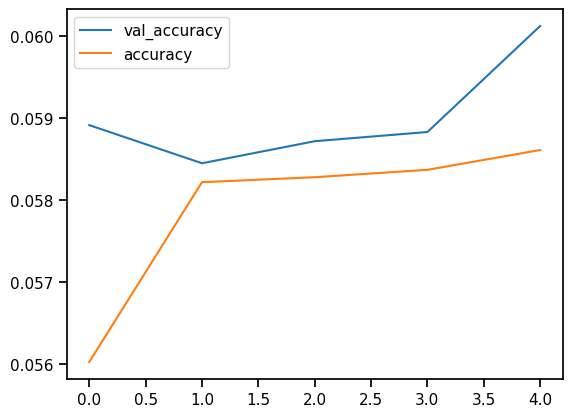

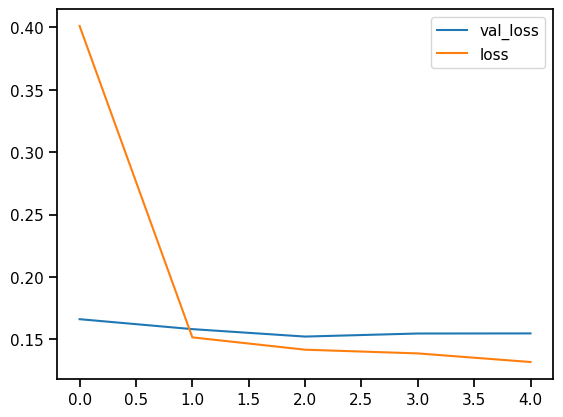

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn

df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [ ]:
loss, accuracy = model.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 399ms/step - accuracy: 0.0590 - loss: 0.5043
Test loss: 0.4784153997898102
Test accuracy: 0.06060395389795303


In [ ]:
strange_sentences = ['The medication is not working'.split(),
                     "anxiety killing depression".split()
                    ]
# convert to integers
strange_sentences_int = [[word2int.get(word, 1) for word in sentence] for sentence in strange_sentences]
# add padding
strange_sentences_int = pad_sequences(strange_sentences_int, maxlen=MAX_LENGTH, padding='post')

predictions = model.predict(strange_sentences_int)
print(predictions, predictions.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
[[[2.15e-01 3.34e-01 2.35e-01 2.15e-01]
  [4.91e-04 9.96e-01 2.08e-03 1.08e-03]
  [1.16e-03 9.82e-01 1.12e-02 5.81e-03]
  ...
  [1.60e-05 9.99e-01 2.59e-04 4.66e-04]
  [1.60e-05 9.99e-01 2.59e-04 4.66e-04]
  [1.60e-05 9.99e-01 2.59e-04 4.66e-04]]

 [[7.26e-05 8.33e-03 9.86e-01 5.55e-03]
  [8.34e-04 9.64e-01 6.62e-03 2.84e-02]
  [2.41e-04 6.90e-01 3.05e-01 4.45e-03]
  ...
  [2.41e-04 6.90e-01 3.05e-01 4.45e-03]
  [2.41e-04 6.90e-01 3.05e-01 4.45e-03]
  [2.41e-04 6.90e-01 3.05e-01 4.45e-03]]] (2, 594, 4)


In [ ]:
def inverse_transform(sentences, predictions):
    output = []
    for sentence, prediction in zip(sentences, predictions):
        # find the index of the highest-scoring tag and translate it back
        token_sequence = [int2tag[np.argmax(prediction[i])] for i in range(len(sentence))]
        output.append(token_sequence)
    return output

print(list(zip(strange_sentences, inverse_transform(strange_sentences, predictions))))

[(['The', 'medication', 'is', 'not', 'working'], ['0', '0', '0', '0', '0']), (['anxiety', 'killing', 'depression'], ['A', '0', '0'])]


In [ ]:
def label_sentence(sentence):
    labels = []
    for word in sentence:
        if word.lower() in mental_health_keywords:
            labels.append('A')
        else:
            labels.append('0')
    return labels

def inverse_transform(sentences):
    output = []
    for sentence in sentences:
        token_sequence = label_sentence(sentence)
        output.append(token_sequence)
    return output

# Take user input for sentences
user_input = input("Enter sentences separated by commas: ")
strange_sentences = [sentence.strip().split() for sentence in user_input.split(",")]

# Get predictions based on rules
predictions = inverse_transform(strange_sentences)

# Print the input sentences and their labels
print(list(zip(strange_sentences, predictions)))


Enter sentences separated by commas: i, am, sad
[(['i'], ['0']), (['am'], ['0']), (['sad'], ['A'])]
